## Telecom Churn Model Assignment
#### Submitted by Arup Mondal, Kousik Das, Kiran Kumar & Viswajit Iyer
##### Jun 17, 2019

In [1]:
#Define the libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

### User-defined Functions 

In [2]:
#Utility Functions

#Replace NAN values of multiple columns with a user defined value
def replaceNAN(df,columnName=[],replacement_value=0):
    for i in columnName:
        df[i] = df[i].replace(to_replace = np.nan, value =replacement_value) 
    return df
        
#Find the columns with unique values - we can drop them
def find_columns_with_unique_values(df):
    columns = list(df)
    for i in columns:
        print(i + '-->' + str(len(df[i].unique().tolist())))
        
#Function to calculate mean and standard deviations from multiple columns of a dataframe
def calculateMean(df,myList = [],newCol=''):
    df[newCol] =  df[myList].mean(axis=1)
    return df
    
def calculateStandardDeviation(df,myList = [],newCol=''):
    df[newCol] =  df[myList].std(axis=1)
    return df

def calculateCoeffofVariation(df,stdCol='',meanCol='', newCol = ''):
    df[newCol] =  df[stdCol]/df[meanCol]
    return df

#Function to get unique values of a column of a dataframe
def getUniqueValues(df,columnName=''):
    print(df[columnName].unique())

#Function to drop columns
def dropColumnbyList(df,colList=[]):
    df = df.drop(colList, 1)
    return df
    
## Function to print confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
#We will drop columns on basis of absolute correlation. But as the dataset is large- we need to have a way

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


In [4]:
from sklearn.metrics import precision_recall_curve

def plotROC(y_pred=[]):
    preds = y_pred
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # Ploting ROC and getting AUC
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plotPrecisionRecallCurve(y_pred=[]):
    preds = y_pred
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    import matplotlib.pyplot as plt
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.plot(recall, precision, marker='.')
    plt.show()

In [5]:
#Import Data
raw_Data = pd.read_csv('telecom_churn_data.csv')


#Drop duplicate mobile numbers keeping the first one
raw_Data = raw_Data.drop_duplicates(subset=['mobile_number'],keep='first')

raw_Data.head(10)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00
5,7000286308,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,50.258,...,0,NaN,NaN,NaN,NaN,1471,0.00,0.00,0.00,0.00
6,7001051193,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,429.023,...,0,NaN,NaN,NaN,NaN,1673,0.00,0.00,0.00,0.00
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,0,NaN,NaN,NaN,NaN,802,57.74,19.38,18.74,0.00
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,0,NaN,1.0,1.0,NaN,315,21.03,910.65,122.16,0.00
9,7001864400,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,119.518,...,0,NaN,1.0,NaN,NaN,902,0.00,0.00,0.00,0.00


## Data Preparation

### Filter High Value Customers

In [6]:
# Filter High Value customers
# Calculate the average recharge amount for the first 2 months 
# by adding total recharge AMOUNT for month 6 & 7
# and dividing it by the sum of NUMBER of recharges over months 6 & 7.
raw_Data['av_rech_amt_first2mo'] = \
    (raw_Data.total_rech_amt_6 + raw_Data.total_rech_amt_7) / \
    (raw_Data.total_rech_num_6 + raw_Data.total_rech_num_7)

# Determine the high value cutoff point at 70th percentile
high_val_cutoff = raw_Data.av_rech_amt_first2mo.quantile(0.7)
print('Threshold recharge amount for filtering high value customers:', high_val_cutoff)


# create the high value (_hv) dataframe from original dataframe using the high value cutoff calculated above.
raw_Data = raw_Data[ (raw_Data.av_rech_amt_first2mo >= high_val_cutoff) ]


Threshold recharge amount for filtering high value customers: 56.38751753155677


In [7]:
raw_Data.shape

(29944, 227)

The filtered data now has 29.9k rows, as per requirement.

### Feature Engineering

In [8]:
# Deriving new features
#
# Ratio of Onnet vs Offnet Users 
#
columnList = ['onnet_mou_6','onnet_mou_7','onnet_mou_8','onnet_mou_9','offnet_mou_6','offnet_mou_7','offnet_mou_8','offnet_mou_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

onnetList = ['onnet_mou_6','onnet_mou_7','onnet_mou_8','onnet_mou_9']
raw_Data = calculateMean(raw_Data,onnetList,newCol='ONNET_USAGE_MEAN')
raw_Data = calculateStandardDeviation(raw_Data,onnetList,newCol='ONNET_USAGE_SD')
#raw_Data = calculateCoeffofVariation(raw_Data,stdCol='ONNET_USAGE_SD',meanCol='ONNET_USAGE_MEAN',newCol ='ONNET_USAGE_COV')

offnetList =['offnet_mou_6','offnet_mou_7','offnet_mou_8','offnet_mou_9']
raw_Data = calculateMean(raw_Data,offnetList,newCol='OFFNET_USAGE_MEAN')
raw_Data = calculateStandardDeviation(raw_Data,offnetList,newCol='OFFNET_USAGE_SD')
#raw_Data = calculateCoeffofVariation(raw_Data,stdCol='OFFNET_USAGE_SD',meanCol='OFFNET_USAGE_MEAN',newCol ='OFFNET_USAGE_COV')


#Get the ratio column
conditions = [
    (raw_Data['ONNET_USAGE_MEAN'] == 0.0) & (raw_Data['OFFNET_USAGE_MEAN'] == 0.0),
    (raw_Data['ONNET_USAGE_MEAN'] == 0.0) & (raw_Data['OFFNET_USAGE_MEAN'] > 0.0),
    (raw_Data['ONNET_USAGE_MEAN'] > 0.0) & (raw_Data['OFFNET_USAGE_MEAN'] == 0.0),
    (raw_Data['ONNET_USAGE_MEAN'] > 0.0) & (raw_Data['OFFNET_USAGE_MEAN'] > 0.0)]

choices = [-1, 0, 1,(raw_Data['ONNET_USAGE_MEAN']/raw_Data['OFFNET_USAGE_MEAN'])]

raw_Data['Ratio_Onnet_by_Offnet'] = np.select(conditions, choices, default=-1)

#raw_Data.head(10)


In [9]:
#
# Consolidate the fb_user columns into a single indicative FB_user column
#
columnList = ['fb_user_6','fb_user_7','fb_user_8','fb_user_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

raw_Data.loc[(raw_Data['fb_user_6']==1) | (raw_Data['fb_user_7']==1)|(raw_Data['fb_user_8']==1)|(raw_Data['fb_user_9']==1), 'FB_user'] = 1 
raw_Data['FB_user']= raw_Data['FB_user'].fillna(0)



In [10]:
#
# Consolidate the data usage volumn for 2g & 3g
#
columnList1 = ['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_2g_mb_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList1,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList1,newCol='2G_Vol_USAGE_MEAN')

columnList2 = ['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','vol_3g_mb_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList2,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList2,newCol='3G_Vol_USAGE_MEAN')

# Consolidation of volume based cost
columnList3 = ['aug_vbc_3g','jul_vbc_3g','jun_vbc_3g','sep_vbc_3g']
raw_Data = replaceNAN(raw_Data,columnName=columnList3,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList3,newCol='3G_Vol_Cost_MEAN')

#raw_Data.head(5)



In [11]:
#
# Roaming Incoming and Outgoing - Consolidation
#
columnList = ['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_ic_mou_9','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','roam_og_mou_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

roam_in=['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_ic_mou_9']
raw_Data = calculateMean(raw_Data,roam_in,newCol='ROAM_INCOMING_USAGE_MEAN')

roam_out=['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','roam_og_mou_9']
raw_Data = calculateMean(raw_Data,roam_out,newCol='ROAM_OUTGOING_USAGE_MEAN')

#raw_Data.head(5)



In [12]:
#
# Consolidate the arpu calls
# 
arpu_call_data = raw_Data[['arpu_6','arpu_7','arpu_8','arpu_9']]
arpu_call_data.corr()

#Remove NAN from arpu data
columnList = ['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

#
# Consolidate the arpu data 2g & 3g
# 
arpu_net_data = raw_Data[['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9']]
arpu_net_data.corr()

#
# Find the mean of arpu calls
# 
arpu_call=['arpu_6','arpu_7','arpu_8','arpu_9']
raw_Data = calculateMean(raw_Data,arpu_call,newCol='ARPU_CALL_MEAN')

#
# Find the mean of arpu data
# 
arpu_data=['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9','arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9']
raw_Data = calculateMean(raw_Data,arpu_data,newCol='ARPU_DATA_MEAN')

#raw_Data.head(5)
#sns.distplot(raw_Data['ARPU_CALL_MEAN'], rug=True, hist=False)




In [13]:
#
# Consolidate Night Pack Users columns into one
# 
#Remove NAN from nightpack users
columnList = ['night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

raw_Data.loc[(raw_Data['night_pck_user_6']==1) | (raw_Data['night_pck_user_7']==1)|(raw_Data['night_pck_user_8']==1)|(raw_Data['night_pck_user_9']==1), 'NIGHT_PACK_USERS'] = 1 
raw_Data['NIGHT_PACK_USERS']= raw_Data['NIGHT_PACK_USERS'].fillna(0)

#raw_Data.head(5)



In [14]:
#
# Consolidate the monthly and sachet users for 2g & 3g
#
# Monthly 3g
columnList = ['monthly_3g_6','monthly_3g_7','monthly_3g_8','monthly_3g_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)


raw_Data.loc[(raw_Data['monthly_3g_6']==1) | (raw_Data['monthly_3g_7']==1)|(raw_Data['monthly_3g_8']==1)|(raw_Data['monthly_3g_9']==1), 'MONTHLY_3G_USERS'] = 1 
raw_Data['MONTHLY_3G_USERS']= raw_Data['MONTHLY_3G_USERS'].fillna(0)

# Monthly 2G
columnList = ['monthly_2g_6','monthly_2g_7','monthly_2g_8','monthly_2g_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

raw_Data.loc[(raw_Data['monthly_2g_6']==1) | (raw_Data['monthly_2g_6']==1)|(raw_Data['monthly_2g_6']==1)|(raw_Data['monthly_2g_6']==1), 'MONTHLY_2G_USERS'] = 1 
raw_Data['MONTHLY_2G_USERS']= raw_Data['MONTHLY_2G_USERS'].fillna(0)

# Sachet 3G
columnList = ['sachet_3g_6','sachet_3g_7','sachet_3g_8','sachet_3g_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

raw_Data.loc[(raw_Data['sachet_3g_6']==1) | (raw_Data['sachet_3g_7']==1)|(raw_Data['sachet_3g_8']==1)|(raw_Data['sachet_3g_9']==1), 'SACHET_3G_USERS'] = 1 
raw_Data['SACHET_3G_USERS']= raw_Data['SACHET_3G_USERS'].fillna(0)

# SACHET 2G 
columnList = ['sachet_2g_6','sachet_2g_7','sachet_2g_8','sachet_2g_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList,replacement_value=0)

raw_Data.loc[(raw_Data['sachet_2g_6']==1) | (raw_Data['sachet_2g_7']==1)|(raw_Data['sachet_2g_8']==1)|(raw_Data['sachet_2g_9']==1), 'SACHET_2G_USERS'] = 1 
raw_Data['SACHET_2G_USERS']= raw_Data['SACHET_2G_USERS'].fillna(0)

#raw_Data.head(5)    


In [15]:
#
# Consolidate mobile to mobile LOCAL for calls
# 
columnList1 = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9'
              ,'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList1,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList1,newCol='LOCAL_M2M_CALL_USAGE_MEAN')


#
# Consolidate mobile to Landline local for calls
#
columnList2 = ['loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
              'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_t2c_mou_9',
              'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','loc_og_mou_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList2,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList2,newCol='LOCAL_M2L_CALL_USAGE_MEAN')


#
# Consolidate the mobile to mobile STD for calls
#
columnList3 = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9',
              'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList3,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList3,newCol='STD_M2M_CALL_USAGE_MEAN')

#
# Consolidate mobile to Landline STD for calls
#
columnList4 = ['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2f_mou_9',
              'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_og_t2c_mou_9',
              'std_og_mou_6','std_og_mou_7','std_og_mou_8','std_og_mou_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList4,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList4,newCol='STD_M2L_CALL_USAGE_MEAN')

#raw_Data.head(5)


In [16]:
#
# Consolidate Local Outgoing Calls
# 
columnList1 = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9',
              'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9',
              'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
              'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_t2c_mou_9',
              'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','loc_og_mou_9']

raw_Data = replaceNAN(raw_Data,columnName=columnList1,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList1,newCol='LOCAL_OUTGOING_CALL_USAGE_MEAN')

#
# Consolidate Local Incoming Calls
# 
columnList2 = ['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9',
              'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
              'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
              'loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','loc_ic_mou_9']

raw_Data = replaceNAN(raw_Data,columnName=columnList2,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList2,newCol='LOCAL_INCOMING_CALL_USAGE_MEAN')

#
# Consolidate STD Outgoing Calls
#
columnList3 = ['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9',
              'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9',
              'std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2f_mou_9',
              'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_og_t2c_mou_9',
              'std_og_mou_6','std_og_mou_7','std_og_mou_8','std_og_mou_9']

raw_Data = replaceNAN(raw_Data,columnName=columnList3,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList3,newCol='STD_OUTGOING_CALL_USAGE_MEAN')

#
# Consolidate STD Incoming Calls
# 
columnList4 = ['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2t_mou_9'
              ,'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9'
              ,'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2f_mou_9'
              ,'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8','std_ic_t2o_mou_9'
              ,'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','std_ic_mou_9']

raw_Data = replaceNAN(raw_Data,columnName=columnList4,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList4,newCol='STD_INCOMING_CALL_USAGE_MEAN')

#
# Consolidate ISD,SPECIAL,OTHERS Outgoing Calls
# 
columnList5 = ['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','isd_og_mou_9',
              'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8','spl_og_mou_9',
              'og_others_6','og_others_7','og_others_8','og_others_9']
raw_Data = replaceNAN(raw_Data,columnName=columnList5,replacement_value=0)

raw_Data = calculateMean(raw_Data,columnList5,newCol='ISD_OUTGOING_CALL_USAGE_MEAN')

#raw_Data.head(5)



### Tag churners and remove attributes of the churn phase

In [17]:
# Add the target Variable based on the criteria provided
# Churn - 1
# No-Churn - 0

raw_Data.loc[(raw_Data['total_ic_mou_9']>0) | (raw_Data['total_og_mou_9']>0)|(raw_Data['vol_2g_mb_9']>0)|(raw_Data['vol_3g_mb_9']>0), 'TARGET'] = 0 
raw_Data['TARGET']= raw_Data['TARGET'].fillna(1)



In [18]:
#
# Drop columns for the final dataset 
#

#Find all columns with *9
month9th_cols = [col for col in raw_Data.columns if '9' in col]
print(month9th_cols)

raw_Data = raw_Data.drop(month9th_cols, axis = 1) 

date_cols = [col for col in raw_Data.columns if 'date' in col]
print(date_cols)

raw_Data = raw_Data.drop(date_cols, axis = 1) 



['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9']
['last_date_of_month_6',

### Final Data Clean up before building Model

In [19]:
#Calculate the missing fields in the High Value Dataset
raw_Data.isnull().sum().sum()

#List of columns with null values
col_Null = raw_Data.columns[raw_Data.isnull().any()].tolist()
print(col_Null)

#Let's analyze the null columns
replaceNAN(raw_Data,col_Null,replacement_value=0)

print(raw_Data.isnull().sum().sum())


['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
0


In [20]:
#
# We will drop columns on basis of absolute correlation. 
# 
print("Top Absolute Correlations")
print(get_top_abs_correlations(raw_Data, 190))

Top Absolute Correlations
STD_M2M_CALL_USAGE_MEAN    STD_OUTGOING_CALL_USAGE_MEAN      0.999714
STD_M2L_CALL_USAGE_MEAN    STD_OUTGOING_CALL_USAGE_MEAN      0.999714
LOCAL_M2L_CALL_USAGE_MEAN  LOCAL_OUTGOING_CALL_USAGE_MEAN    0.998940
STD_M2M_CALL_USAGE_MEAN    STD_M2L_CALL_USAGE_MEAN           0.998855
LOCAL_M2M_CALL_USAGE_MEAN  LOCAL_OUTGOING_CALL_USAGE_MEAN    0.998070
                           LOCAL_M2L_CALL_USAGE_MEAN         0.994210
arpu_8                     total_rech_amt_8                  0.947053
isd_og_mou_7               isd_og_mou_8                      0.943772
loc_ic_mou_7               LOCAL_INCOMING_CALL_USAGE_MEAN    0.942076
loc_og_mou_8               LOCAL_OUTGOING_CALL_USAGE_MEAN    0.941073
                           LOCAL_M2L_CALL_USAGE_MEAN         0.940328
loc_ic_mou_8               LOCAL_INCOMING_CALL_USAGE_MEAN    0.939877
loc_og_mou_8               LOCAL_M2M_CALL_USAGE_MEAN         0.939356
arpu_6                     total_rech_amt_6                  0.9

In [21]:
#Addition columns to be dropped based on correlation

add_colToDrop = ['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou',
                 'onnet_mou_6','onnet_mou_7','onnet_mou_8',
                 'offnet_mou_6','offnet_mou_7','offnet_mou_8',
                 'vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8',
                 'vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                    'aug_vbc_3g','jul_vbc_3g','jun_vbc_3g',
                    'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8',
                    'roam_og_mou_6','roam_og_mou_7','roam_og_mou_8',
                    'arpu_6','arpu_7','arpu_8',
                    'arpu_3g_6','arpu_3g_7','arpu_3g_8',
                    'arpu_2g_6','arpu_2g_7','arpu_2g_8',
                    'night_pck_user_6','night_pck_user_7','night_pck_user_8',
                    'monthly_3g_6','monthly_3g_7','monthly_3g_8',
                    'monthly_2g_6','monthly_2g_7','monthly_2g_8',
                    'sachet_3g_6','sachet_3g_7','sachet_3g_8',
                    'sachet_2g_6','sachet_2g_7','sachet_2g_8',
'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8',              
'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',              
'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8',              
'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8',
'loc_og_mou_6','loc_og_mou_7','loc_og_mou_8',
'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8',              
'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',              
'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8',
'loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8',
'std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8',              
'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8',              
'std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8',              
'std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8',
'std_og_mou_6','std_og_mou_7','std_og_mou_8',
'std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8',              
'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',              
'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8',              
'std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8',              
'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8',
'isd_og_mou_6','isd_og_mou_7','isd_og_mou_8',
'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8',
'og_others_6','og_others_7','og_others_8',
'fb_user_6','fb_user_7','fb_user_8',
'ARPU_CALL_MEAN','ARPU_DATA_MEAN','max_rech_data_8',
'max_rech_data_7','max_rech_data_6','total_ic_mou_7',
'total_ic_mou_8','total_ic_mou_6','total_og_mou_7',
'STD_OUTGOING_CALL_USAGE_MEAN','LOCAL_OUTGOING_CALL_USAGE_MEAN',
'STD_M2L_CALL_USAGE_MEAN', 'LOCAL_M2L_CALL_USAGE_MEAN']

raw_Data = raw_Data.drop(add_colToDrop, axis = 1) 




In [22]:
raw_Data.head()
print("Top Absolute Correlations")
print(get_top_abs_correlations(raw_Data,70))

Top Absolute Correlations
total_rech_data_8   count_rech_2g_8            0.784805
isd_ic_mou_7        isd_ic_mou_8               0.779856
count_rech_3g_7     av_rech_amt_data_7         0.776505
av_rech_amt_data_8  3G_Vol_USAGE_MEAN          0.775957
av_rech_amt_data_7  3G_Vol_USAGE_MEAN          0.774462
isd_ic_mou_6        isd_ic_mou_7               0.773384
count_rech_3g_6     av_rech_amt_data_6         0.772170
ONNET_USAGE_MEAN    ONNET_USAGE_SD             0.761582
total_rech_data_6   av_rech_amt_data_6         0.755872
total_rech_data_7   av_rech_amt_data_7         0.753170
total_og_mou_8      STD_M2M_CALL_USAGE_MEAN    0.747902
total_rech_data_6   count_rech_3g_6            0.746405
total_rech_data_7   count_rech_3g_7            0.735918
av_rech_amt_data_6  3G_Vol_USAGE_MEAN          0.735538
total_rech_amt_7    total_rech_amt_8           0.729898
total_rech_data_6   count_rech_2g_6            0.725833
total_rech_data_7   count_rech_2g_7            0.723636
count_rech_3g_8     av

In [23]:
raw_Data.shape

(29944, 61)

### Feature Selection based on Random Forest & Extra Tree Classifiers

In [24]:
#Find the important features

#Feature Selection: Random Forest Regressor with Shuffle

from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from collections import defaultdict

Y = raw_Data['TARGET']
X = raw_Data.drop(['TARGET'], axis = 1)

rf = RandomForestClassifier()
scores = defaultdict(list)

rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
rs.get_n_splits(X)

names = list(X)

rf = RandomForestClassifier()
rf.fit(X, Y)



feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                                importance
total_og_mou_8                    0.218909
max_rech_amt_8                    0.037235
LOCAL_M2M_CALL_USAGE_MEAN         0.035735
OFFNET_USAGE_SD                   0.033125
LOCAL_INCOMING_CALL_USAGE_MEAN    0.032956
ONNET_USAGE_SD                    0.028722
Ratio_Onnet_by_Offnet             0.028572
last_day_rch_amt_8                0.027247
total_og_mou_6                    0.025567
av_rech_amt_data_8                0.024436
OFFNET_USAGE_MEAN                 0.024069
aon                               0.023391
total_rech_num_8                  0.022691
mobile_number                     0.021459
total_rech_amt_8                  0.018935
STD_INCOMING_CALL_USAGE_MEAN      0.018853
av_rech_amt_first2mo              0.018601
total_rech_amt_6                  0.018079
ISD_OUTGOING_CALL_USAGE_MEAN      0.017993
STD_M2M_CALL_USAGE_MEAN           0.017563
total_rech_amt_7                  0.017335
ROAM_INCOMING_USAGE_MEAN          0.017134
ROAM_OUTGOI

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
y = raw_Data['TARGET']
X = raw_Data.drop(['TARGET'], axis = 1)
model.fit(X,y)
#print(model.feature_importances_) 
feat_importances = pd.DataFrame(model.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feat_importances)
#feat_importances.nlargest(30).plot(kind='barh')
#plt.show()

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


                                importance
total_og_mou_8                    0.083852
max_rech_amt_8                    0.044279
LOCAL_INCOMING_CALL_USAGE_MEAN    0.038822
OFFNET_USAGE_SD                   0.038022
LOCAL_M2M_CALL_USAGE_MEAN         0.037770
total_rech_num_8                  0.034049
total_rech_amt_8                  0.031743
last_day_rch_amt_8                0.031075
ONNET_USAGE_SD                    0.029703
total_rech_num_7                  0.029588
aon                               0.026808
ROAM_OUTGOING_USAGE_MEAN          0.026329
total_og_mou_6                    0.025622
OFFNET_USAGE_MEAN                 0.025065
total_rech_num_6                  0.024137
ROAM_INCOMING_USAGE_MEAN          0.024054
ONNET_USAGE_MEAN                  0.022023
max_rech_amt_7                    0.020615
total_rech_amt_6                  0.020479
mobile_number                     0.020388
total_rech_amt_7                  0.019578
av_rech_amt_first2mo              0.019260
last_day_rc

In [26]:
#Select the TOP features from the above two feature selection techniques 

selected_Features = [ 'mobile_number','total_og_mou_8','total_rech_amt_8','LOCAL_INCOMING_CALL_USAGE_MEAN',
                     'LOCAL_M2M_CALL_USAGE_MEAN','total_rech_num_8','OFFNET_USAGE_SD','OFFNET_USAGE_MEAN',
                     'ONNET_USAGE_SD','aon','ROAM_OUTGOING_USAGE_MEAN','ROAM_INCOMING_USAGE_MEAN',
                     'total_og_mou_6','total_rech_amt_7','total_rech_num_6','ONNET_USAGE_MEAN',
                     'Ratio_Onnet_by_Offnet','max_rech_amt_7','total_rech_amt_6','STD_M2M_CALL_USAGE_MEAN',
                     'total_rech_amt_7','last_day_rch_amt_8','STD_INCOMING_CALL_USAGE_MEAN',
                     'av_rech_amt_first2mo','max_rech_amt_8','ISD_OUTGOING_CALL_USAGE_MEAN',
                     'max_rech_amt_6','3G_Vol_Cost_MEAN','last_day_rch_amt_7',
                     'last_day_rch_amt_6','2G_Vol_USAGE_MEAN','TARGET']


churn_Data = raw_Data[selected_Features]
churn_Data.head(10)

,mobile_number,total_og_mou_8,total_rech_amt_8,LOCAL_INCOMING_CALL_USAGE_MEAN,LOCAL_M2M_CALL_USAGE_MEAN,total_rech_num_8,OFFNET_USAGE_SD,OFFNET_USAGE_MEAN,ONNET_USAGE_SD,aon,...,STD_INCOMING_CALL_USAGE_MEAN,av_rech_amt_first2mo,max_rech_amt_8,ISD_OUTGOING_CALL_USAGE_MEAN,max_rech_amt_6,3G_Vol_Cost_MEAN,last_day_rch_amt_7,last_day_rch_amt_6,2G_Vol_USAGE_MEAN,TARGET
0,7000842753,0.00,252,0.680000,0.00000,2,0.000000,0.0000,0.000000,968,...,0.0000,87.714286,252,0.000000,252,33.7950,252,252,9.3000,1.0
7,7000701601,350.16,3638,121.390625,130.16750,7,245.099297,336.6250,27.562221,802,...,54.7535,237.000000,1580,1.765833,1580,23.9650,0,0,0.0000,1.0
9,7001864400,100.78,210,129.338125,33.06875,5,30.734395,79.8650,4.792580,902,...,11.8670,69.166667,50,0.055000,110,0.0000,154,110,1.8425,0.0
13,7002191713,1015.26,717,79.403125,87.38500,11,169.277250,307.2775,205.253212,2607,...,118.0205,76.000000,130,0.505833,110,0.0000,50,110,0.0050,0.0
16,7000875565,233.38,160,125.843750,118.88500,2,54.575615,228.2950,19.786718,511,...,36.8390,57.375000,130,0.764167,110,6.0850,100,100,0.0000,0.0
19,7001754084,23.08,428,35.615625,7.66250,4,18.838876,13.5900,7.978766,1104,...,0.0000,89.600000,274,0.079167,154,230.1475,154,154,298.8975,0.0
20,7001028254,203.69,477,83.576875,108.99875,3,46.920331,198.5775,12.458900,3108,...,12.4985,85.875000,250,0.757500,250,0.3325,0,120,0.0000,0.0
22,7001121249,0.00,0,10.423750,6.19750,1,193.384609,98.4550,17.513786,396,...,17.1895,57.000000,0,3.930000,110,0.0000,30,37,0.0000,0.0
23,7000887461,239.48,439,79.552500,68.39750,4,56.388507,123.1350,16.259359,604,...,8.1400,56.750000,179,2.347500,0,23.0775,179,0,3.6050,0.0
24,7001125315,403.64,490,122.017500,97.76875,7,88.810094,396.5075,40.306020,3072,...,33.1320,77.000000,130,3.316667,110,0.0000,110,110,0.0000,0.0


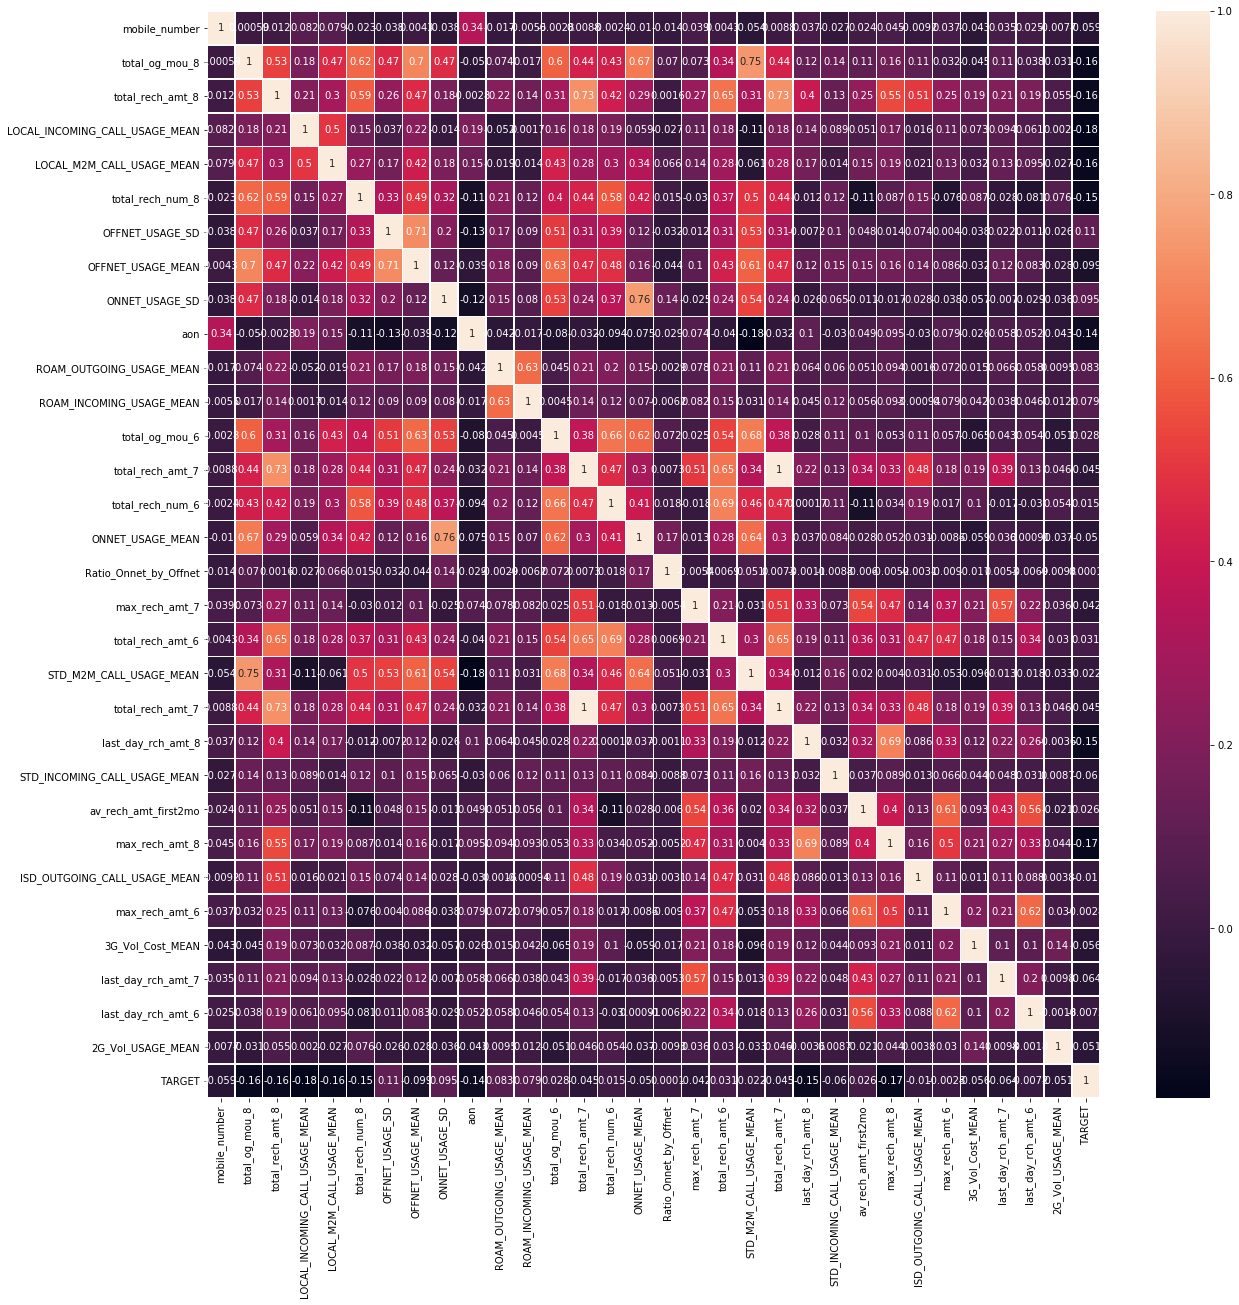

In [27]:
#View the correlation matrix
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(churn_Data.corr(),annot =True, linewidths=.5, ax=ax)
plt.show()

In [28]:
X = churn_Data.iloc[:,1:31]
X.head(10)
y = churn_Data.iloc[:,-1]
y.head(10)

0     1.0
7     1.0
9     0.0
13    0.0
16    0.0
19    0.0
20    0.0
22    0.0
23    0.0
24    0.0
Name: TARGET, dtype: float64

### Analyzing Class Imbalance in Data


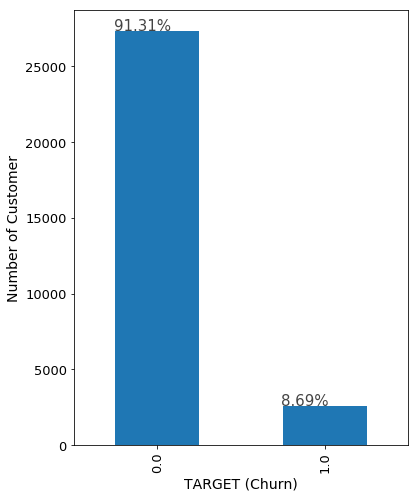

In [29]:
#
# Actual Churn Percentages in High Value Customer data considered for Modelling
#


def plotImbalance(df):
    ax = df["TARGET"].value_counts().plot(kind='bar', figsize=(6, 8), fontsize=13)
    ax.set_ylabel("Number of Customer", fontsize=14);
    ax.set_xlabel("TARGET (Churn)", fontsize=14);

    totals = []
    for i in ax.patches:
        totals.append(i.get_height())

    total = sum(totals)

    for i in ax.patches:
        ax.text(i.get_x() - .01, i.get_height() + .5, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                    color='#444444')
    plt.show()
    
plotImbalance(churn_Data)


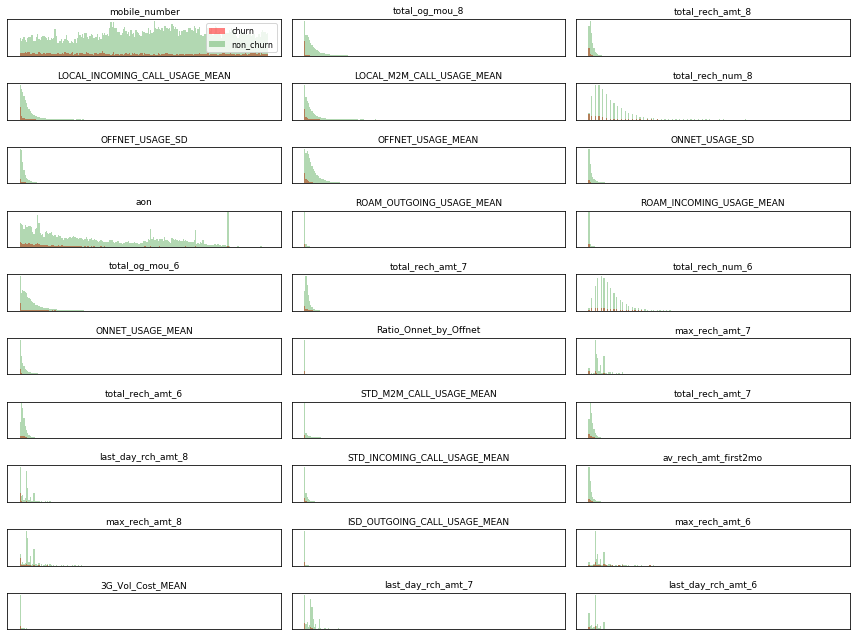

In [30]:
#
# Plot probability distribution graph of feature
#
fig,axes =plt.subplots(10,3, figsize=(12, 9)) 
churn=churn_Data[churn_Data.TARGET==1] 
non_churn=churn_Data[churn_Data.TARGET==0]
ax=axes.ravel()
for i in range(30):
  _,bins=np.histogram(churn_Data.iloc[:,i],bins=200)
  ax[i].hist(churn.iloc[:,i],bins=bins,color='r',alpha=.5)# red color for churn class
  ax[i].hist(non_churn.iloc[:,i],bins=bins,color='g',alpha=0.3)
  ax[i].set_title(churn_Data.columns[i],fontsize=9)
  ax[i].axes.get_xaxis().set_visible(False) 
  ax[i].set_yticks(())
ax[0].legend(['churn','non_churn'],loc='best',fontsize=8)
plt.tight_layout()
plt.show()



In [31]:
# 
# Determine the number of principal axes for PCA.
# 
cols_to_norm = ['total_og_mou_8', 'total_rech_amt_8',
       'LOCAL_INCOMING_CALL_USAGE_MEAN', 'LOCAL_M2M_CALL_USAGE_MEAN',
       'total_rech_num_8', 'OFFNET_USAGE_SD', 'OFFNET_USAGE_MEAN',
       'ONNET_USAGE_SD', 'aon', 'ROAM_OUTGOING_USAGE_MEAN',
       'ROAM_INCOMING_USAGE_MEAN', 'total_og_mou_6', 'total_rech_amt_7',
       'total_rech_num_6', 'ONNET_USAGE_MEAN', 'Ratio_Onnet_by_Offnet',
       'max_rech_amt_7', 'total_rech_amt_6', 'STD_M2M_CALL_USAGE_MEAN',
       'total_rech_amt_7', 'last_day_rch_amt_8',
       'STD_INCOMING_CALL_USAGE_MEAN', 'av_rech_amt_first2mo',
       'max_rech_amt_8', 'ISD_OUTGOING_CALL_USAGE_MEAN', 'max_rech_amt_6',
       '3G_Vol_Cost_MEAN', 'last_day_rch_amt_7', 'last_day_rch_amt_6',
       '2G_Vol_USAGE_MEAN']

churn_Data[cols_to_norm] = sklearn.preprocessing.normalize(churn_Data[cols_to_norm])

#churn_Data.head(10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
#
# Run PCA to check components
#
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
principalComponents = pca.fit_transform(churn_Data.iloc[:,1:31])
print(pca.explained_variance_ratio_)
print('Explained variation per principal component: {}'.format(sum(pca.explained_variance_ratio_)))


[0.44519056 0.1352765  0.10490718 0.07145589 0.04014194 0.03176407
 0.03105221 0.02702903 0.02377238 0.02020102]
Explained variation per principal component: 0.9307907722838152


In [33]:
#principal_churn_Data_Df = pd.DataFrame(data = principalComponents
#             , columns = ['pc1', 'pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10'])

#principal_churn_Data_Df.head(5)

### Modeling on Imbalanced data

In [34]:
#
# Separate Features and Labels
#
N_COMPONENTS = 10
TARGET_FEATURE = 'TARGET'  
TEST_SET_SIZE = 0.2

X = churn_Data.iloc[:,1:31]
y = churn_Data[TARGET_FEATURE]

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SET_SIZE
)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

pca = PCA(n_components= 10) 
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


#### Build a Logistic Regression model 

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*********************************************************************************************
At Cutoff ..............0.2
Recall metric in the train dataset: 65.35714285714286%


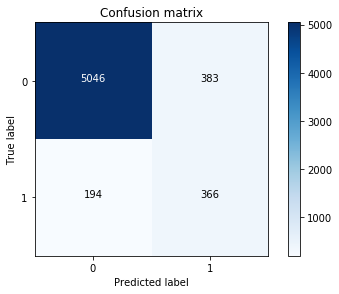

Accuracy:  0.90
Precision: 0.49
Recall:    0.65


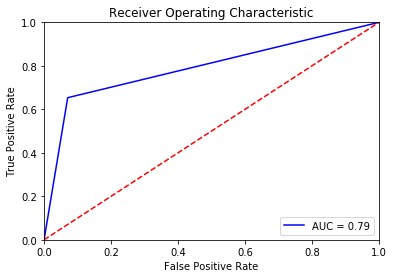

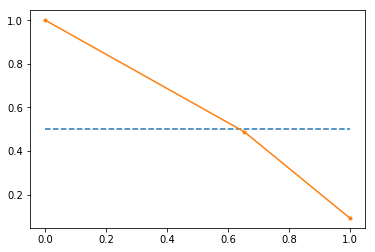

*********************************************************************************************
At Cutoff ..............0.3
Recall metric in the train dataset: 53.392857142857146%


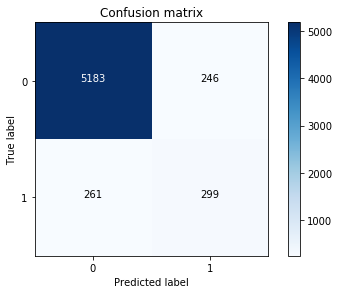

Accuracy:  0.92
Precision: 0.55
Recall:    0.53


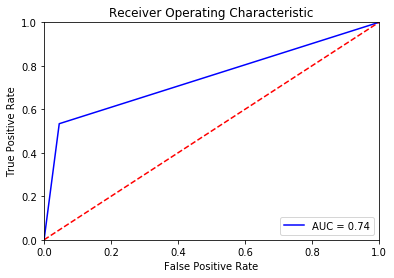

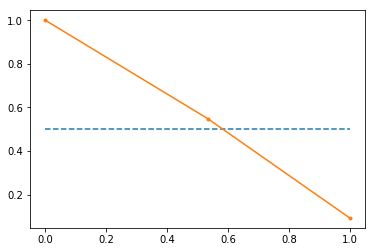

*********************************************************************************************
At Cutoff ..............0.4
Recall metric in the train dataset: 40.357142857142854%


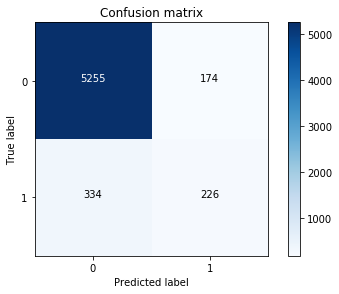

Accuracy:  0.92
Precision: 0.56
Recall:    0.40


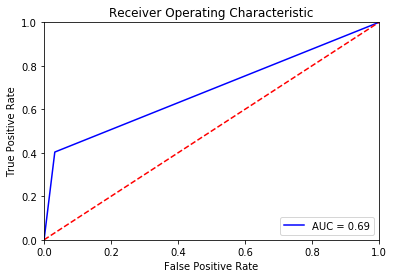

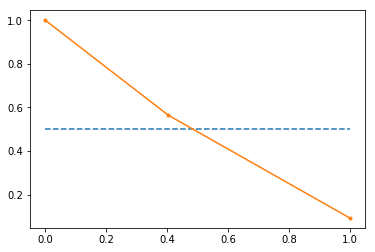

*********************************************************************************************
At Cutoff ..............0.5
Recall metric in the train dataset: 30.535714285714285%


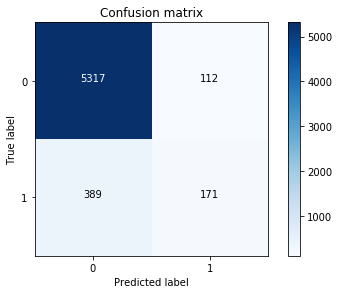

Accuracy:  0.92
Precision: 0.60
Recall:    0.31


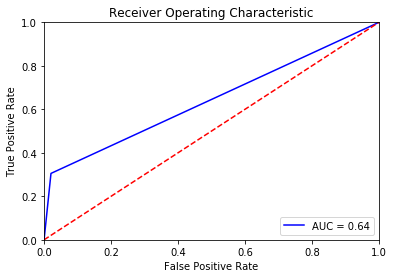

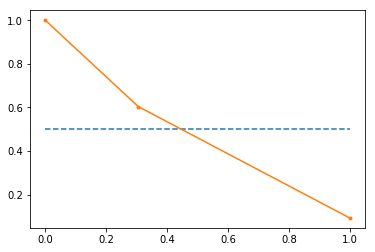

*********************************************************************************************
At Cutoff ..............0.6
Recall metric in the train dataset: 22.321428571428573%


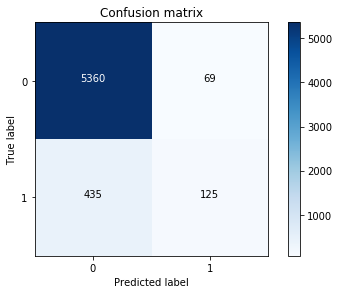

Accuracy:  0.92
Precision: 0.64
Recall:    0.22


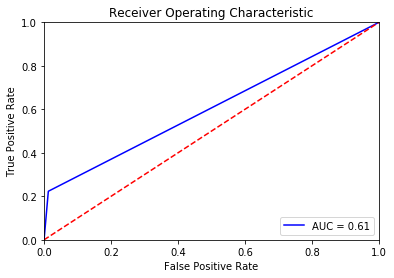

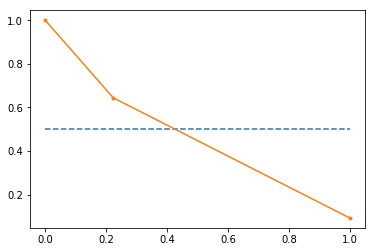

*********************************************************************************************
At Cutoff ..............0.7
Recall metric in the train dataset: 12.5%


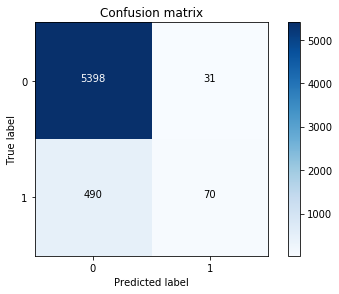

Accuracy:  0.91
Precision: 0.69
Recall:    0.12


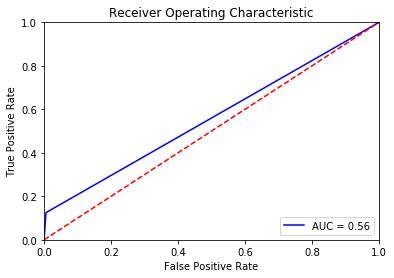

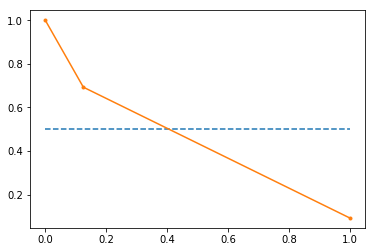

*********************************************************************************************
At Cutoff ..............0.8
Recall metric in the train dataset: 4.642857142857143%


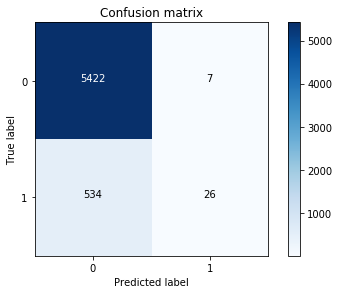

Accuracy:  0.91
Precision: 0.79
Recall:    0.05


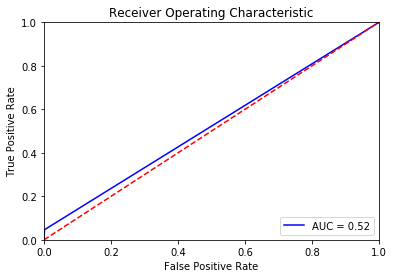

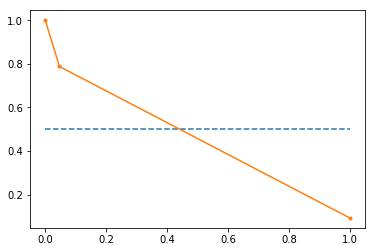

In [35]:
#
# Logistic regression - With PCA - Unbalanced Data
# 
pca_model = decomposition.PCA(n_components=N_COMPONENTS)
pca_model.fit(X)
pca_data = pd.DataFrame(pca_model.transform(X))

#pca_data['intercept'] = 1.0
logit_model = LogisticRegression(random_state=0).fit(x_train, y_train)

# Get prediction probabilities for the test set.
y_predict_proba = logit_model.predict_proba(x_test)

n_samples = len(y_test)
cutoff = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
class_names = [0,1]

for i in cutoff:
    index = cutoff.index(i)
    print('*********************************************************************************************')
    Case = 'At Cutoff ..............'
    print(Case + str(cutoff[index]))
    y_predict = [int(proba[1] > cutoff[index]) for proba in y_predict_proba]
    M = confusion_matrix(y_test, y_predict)
        
    print("Recall metric in the train dataset: {}%".format(100*M[1,1]/(M[1,0]+M[1,1])))
   
    plt.figure()
    plot_confusion_matrix(M , classes=class_names, title='Confusion matrix')
    plt.show()
    print('Accuracy:  %.2f' % ((M[0][0] + M[1][1]) / n_samples))
    print('Precision: %.2f' % (M[1][1] / (M[0][1] + M[1][1])))
    print('Recall:    %.2f' % (M[1][1] / (M[1][0] + M[1][1])))
    
    plotROC(y_predict)
    
    plotPrecisionRecallCurve(y_predict)

#### Build a penalized SVM model

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


*********************************************************************************************
At Cutoff ..............0.2
Recall metric in the train dataset: 71.60714285714286%


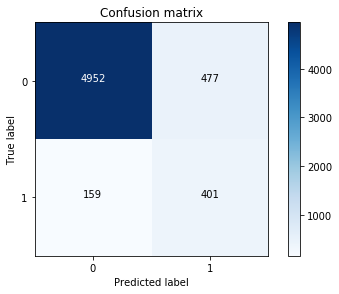

Accuracy:  0.89
Precision: 0.46
Recall:    0.72


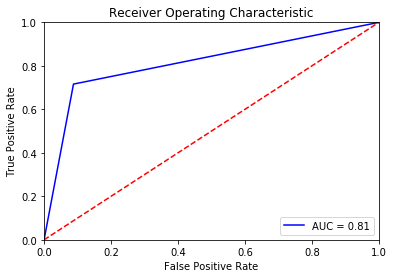

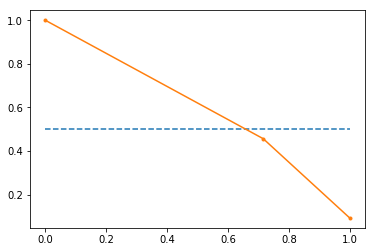

*********************************************************************************************
At Cutoff ..............0.3
Recall metric in the train dataset: 61.964285714285715%


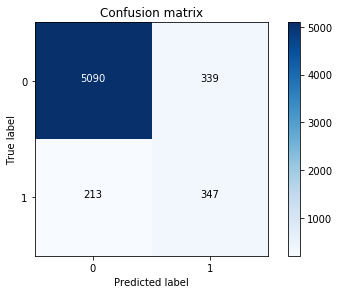

Accuracy:  0.91
Precision: 0.51
Recall:    0.62


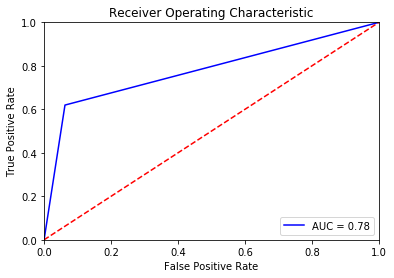

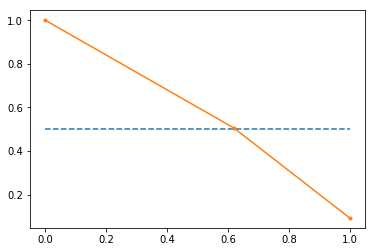

*********************************************************************************************
At Cutoff ..............0.4
Recall metric in the train dataset: 52.142857142857146%


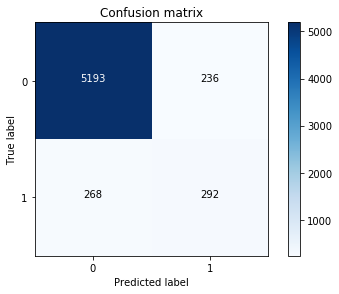

Accuracy:  0.92
Precision: 0.55
Recall:    0.52


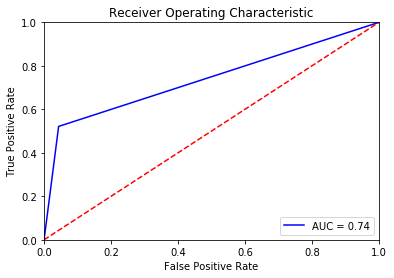

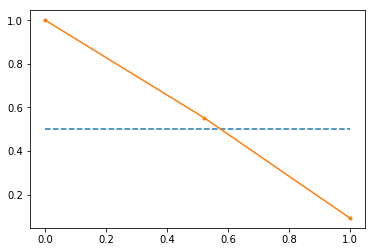

*********************************************************************************************
At Cutoff ..............0.5
Recall metric in the train dataset: 31.964285714285715%


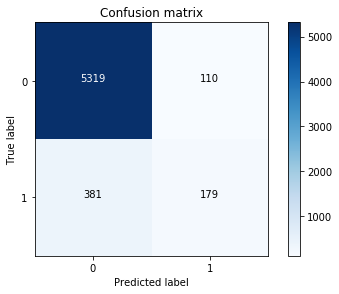

Accuracy:  0.92
Precision: 0.62
Recall:    0.32


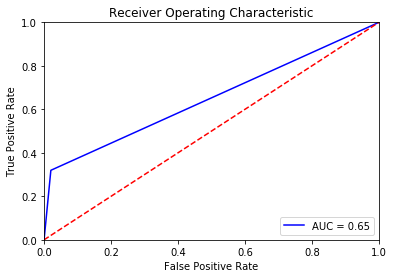

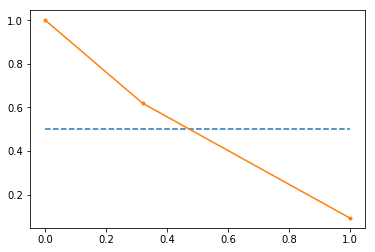

*********************************************************************************************
At Cutoff ..............0.6
Recall metric in the train dataset: 12.321428571428571%


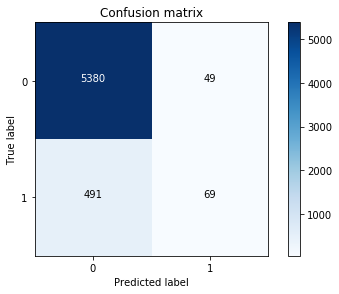

Accuracy:  0.91
Precision: 0.58
Recall:    0.12


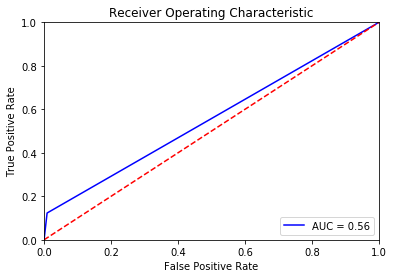

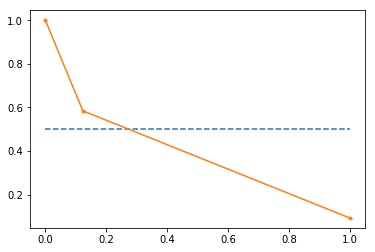

*********************************************************************************************
At Cutoff ..............0.7
Recall metric in the train dataset: 3.0357142857142856%


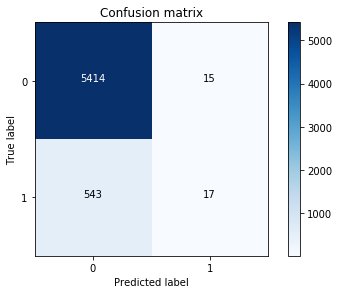

Accuracy:  0.91
Precision: 0.53
Recall:    0.03


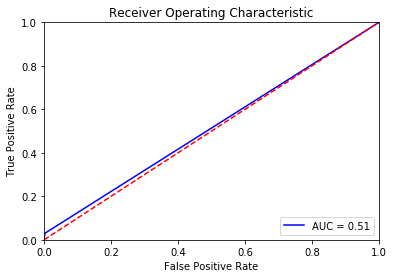

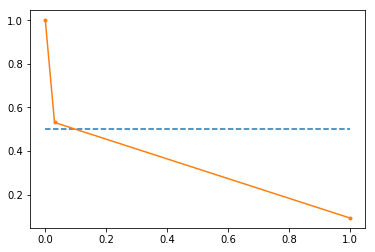

*********************************************************************************************
At Cutoff ..............0.8
Recall metric in the train dataset: 0.35714285714285715%


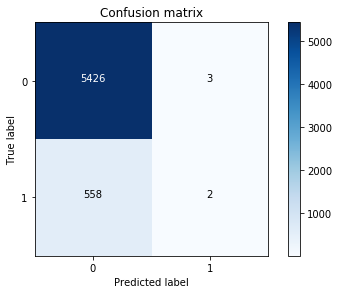

Accuracy:  0.91
Precision: 0.40
Recall:    0.00


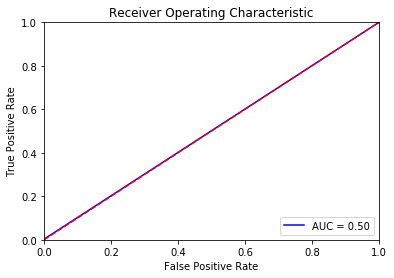

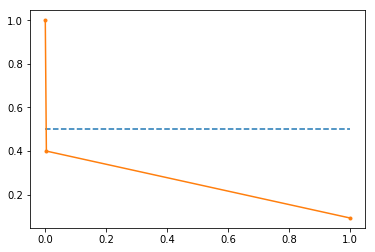

In [36]:
#Penalized SVM on imbalanced Dataset

#Imbalance in dataset - Let's try SVC without PCA first with Linear Kernel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

SVC_classifier = SVC(kernel='rbf', class_weight='balanced', probability=True).fit(x_train, y_train)
# Get prediction probabilities for the test set.
y_predict_proba = SVC_classifier.predict_proba(x_test)

n_samples = len(y_test)
cutoff = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
class_names = [0,1]

for i in cutoff:
    index = cutoff.index(i)
    print('*********************************************************************************************')
    Case = 'At Cutoff ..............'
    print(Case + str(cutoff[index]))
    y_predict = [int(proba[1] > cutoff[index]) for proba in y_predict_proba]
    M = confusion_matrix(y_test, y_predict)
        
    print("Recall metric in the train dataset: {}%".format(100*M[1,1]/(M[1,0]+M[1,1])))
   
    plt.figure()
    plot_confusion_matrix(M , classes=class_names, title='Confusion matrix')
    plt.show()
    print('Accuracy:  %.2f' % ((M[0][0] + M[1][1]) / n_samples))
    print('Precision: %.2f' % (M[1][1] / (M[0][1] + M[1][1])))
    print('Recall:    %.2f' % (M[1][1] / (M[1][0] + M[1][1])))
    
    plotROC(y_predict)
    
    plotPrecisionRecallCurve(y_predict)

#### Build Weighted Random Forest Classifier model

*********************************************************************************************
At Cutoff ..............0.2
Recall metric in the train dataset: 68.21428571428571%


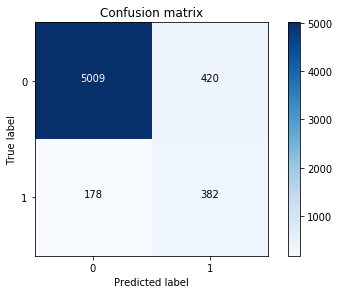

Accuracy:  0.90
Precision: 0.48
Recall:    0.68


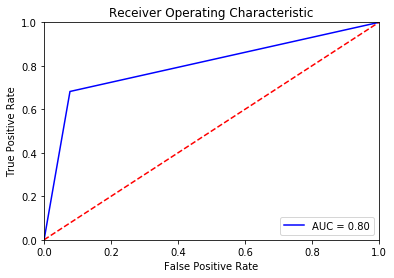

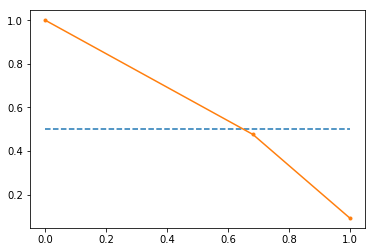

*********************************************************************************************
At Cutoff ..............0.3
Recall metric in the train dataset: 58.392857142857146%


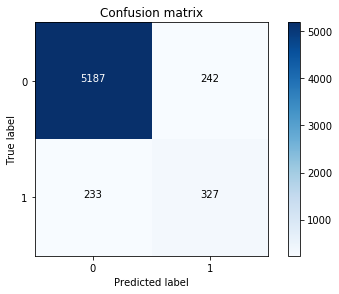

Accuracy:  0.92
Precision: 0.57
Recall:    0.58


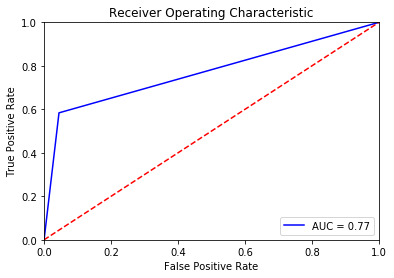

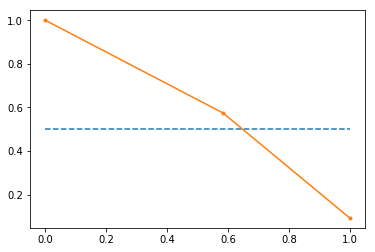

*********************************************************************************************
At Cutoff ..............0.4
Recall metric in the train dataset: 45.892857142857146%


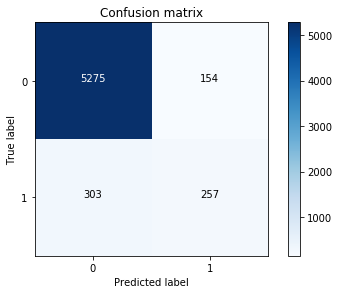

Accuracy:  0.92
Precision: 0.63
Recall:    0.46


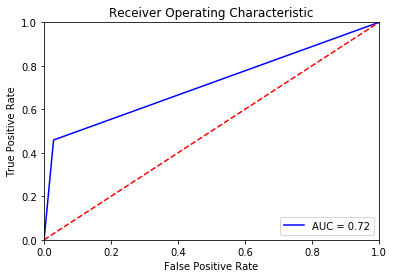

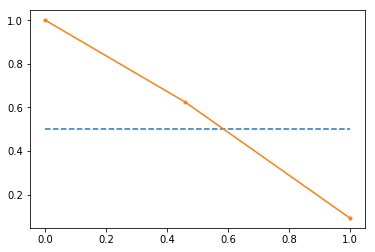

*********************************************************************************************
At Cutoff ..............0.5
Recall metric in the train dataset: 34.82142857142857%


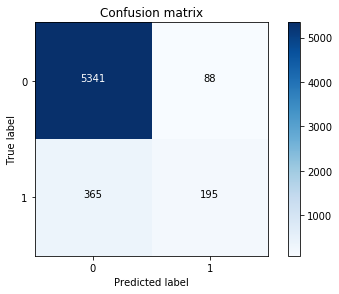

Accuracy:  0.92
Precision: 0.69
Recall:    0.35


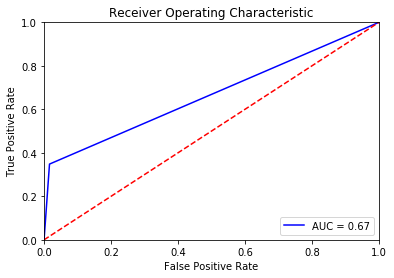

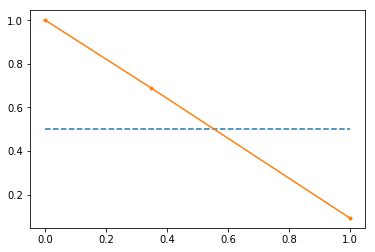

*********************************************************************************************
At Cutoff ..............0.6
Recall metric in the train dataset: 23.214285714285715%


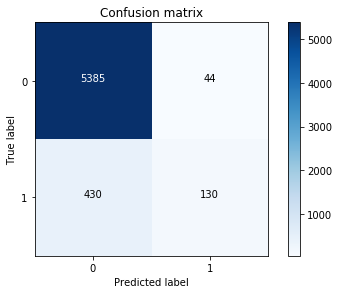

Accuracy:  0.92
Precision: 0.75
Recall:    0.23


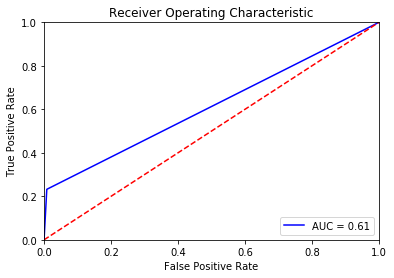

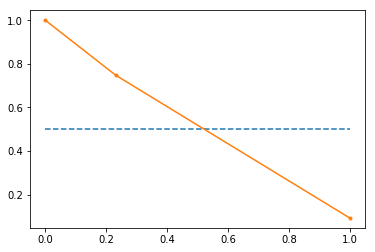

*********************************************************************************************
At Cutoff ..............0.7
Recall metric in the train dataset: 15.892857142857142%


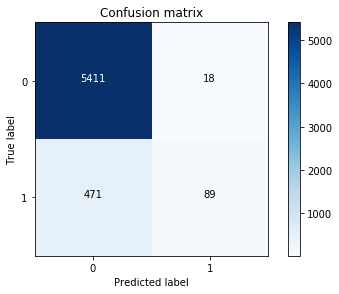

Accuracy:  0.92
Precision: 0.83
Recall:    0.16


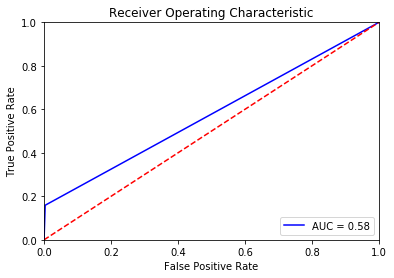

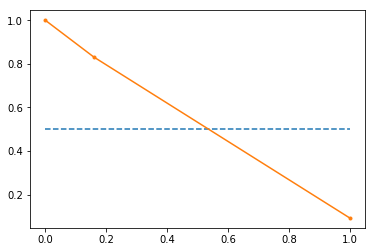

*********************************************************************************************
At Cutoff ..............0.8
Recall metric in the train dataset: 7.678571428571429%


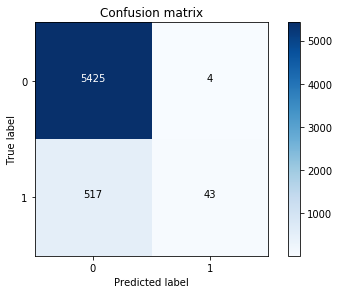

Accuracy:  0.91
Precision: 0.91
Recall:    0.08


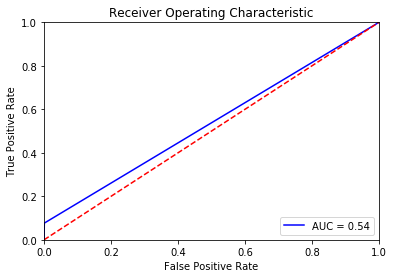

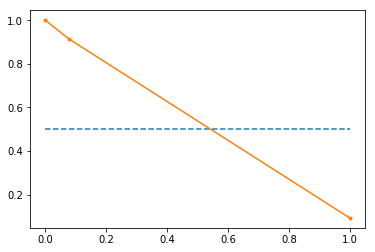

In [37]:
#Random Forest Classifier on Imbalanced Dataset
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(class_weight='balanced',n_estimators=400).fit(x_train, y_train)

y_predict_proba = RFC.predict_proba(x_test)

n_samples = len(y_test)
cutoff = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
class_names = [0,1]

for i in cutoff:
    index = cutoff.index(i)
    print('*********************************************************************************************')
    Case = 'At Cutoff ..............'
    print(Case + str(cutoff[index]))
    y_predict = [int(proba[1] > cutoff[index]) for proba in y_predict_proba]
    M = confusion_matrix(y_test, y_predict)
        
    print("Recall metric in the train dataset: {}%".format(100*M[1,1]/(M[1,0]+M[1,1])))
   
    plt.figure()
    plot_confusion_matrix(M , classes=class_names, title='Confusion matrix')
    plt.show()
    print('Accuracy:  %.2f' % ((M[0][0] + M[1][1]) / n_samples))
    print('Precision: %.2f' % (M[1][1] / (M[0][1] + M[1][1])))
    print('Recall:    %.2f' % (M[1][1] / (M[1][0] + M[1][1])))
    
    plotROC(y_predict)
    
    plotPrecisionRecallCurve(y_predict)

#### Partial Balancing of the data

(19523, 31)
(2602, 32)
(27342, 32)
(29944, 32)


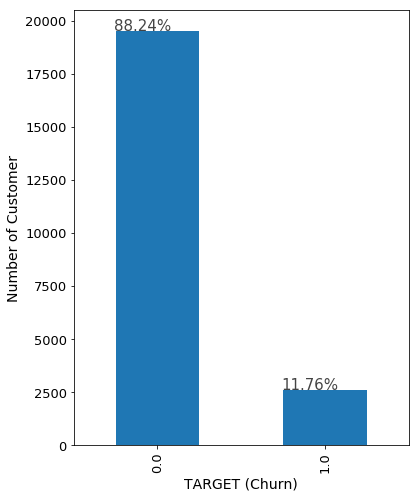

In [38]:
# Balancing the original - we will do partial balancing by undersampling
# 1. Balacing can be done by over-sampling or under sampling - SMOTE
# 2. Here we will try to reduce the no_churn data by removing the outliers and try to get a balanced dataset

# Check for outliers for each column by determining the number (and %age) of values that fall 
# either above or below 3 times the standard deviation from the mean for that column.

df = churn_Data.loc[churn_Data['TARGET'] == 0]


#Removing outliers
Non_churn_data_no_Outliers = df.iloc[:,1:31][df.iloc[:,1:31].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
Non_churn_data_no_Outliers['TARGET']=0
print(Non_churn_data_no_Outliers.shape)

churn_data_all = churn_Data.loc[churn_Data['TARGET'] == 1]


print(churn_data_all.shape)
print(df.shape)
print(churn_Data.shape)

churn_Data_Partial_Balanced = pd.concat([Non_churn_data_no_Outliers, churn_data_all.iloc[:,1:32]], ignore_index=True)
#print(churn_Data_Partal_Balanced.shape)

churn_Data_Partial_Balanced.head(5)
plotImbalance(churn_Data_Partial_Balanced)

### Modeling with Partially Balanced Data

In [39]:
# 
# Modeling the new data
# Separate Features and Labels
# 
N_COMPONENTS = 10
TARGET_FEATURE = 'TARGET'  
TEST_SET_SIZE = 0.2

X = churn_Data_Partial_Balanced.iloc[:,0:30]
y = churn_Data_Partial_Balanced[TARGET_FEATURE]

x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SET_SIZE
)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

pca = PCA(n_components= 10) 
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)


#### First, with Logistic Regression model

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


*********************************************************************************************
At Cutoff ..............0.2
Recall metric in the train dataset: 77.99607072691552%


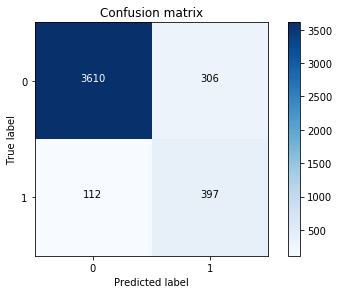

Accuracy:  0.91
Precision: 0.56
Recall:    0.78


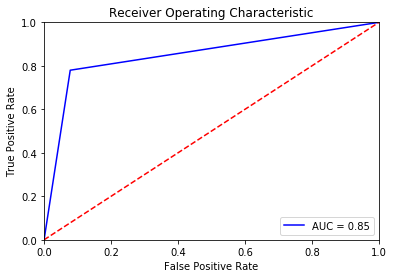

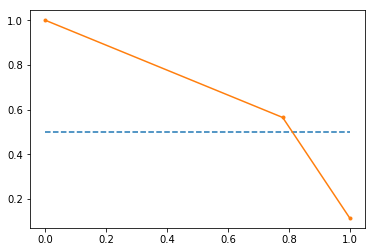

*********************************************************************************************
At Cutoff ..............0.3
Recall metric in the train dataset: 69.15520628683693%


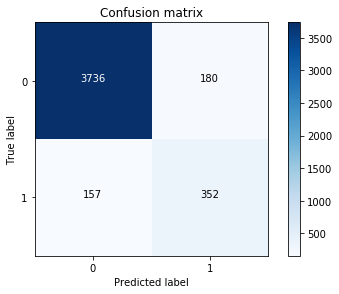

Accuracy:  0.92
Precision: 0.66
Recall:    0.69


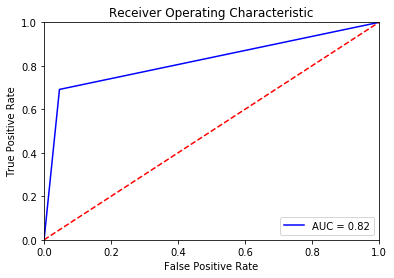

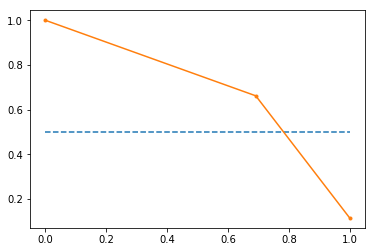

*********************************************************************************************
At Cutoff ..............0.4
Recall metric in the train dataset: 65.6188605108055%


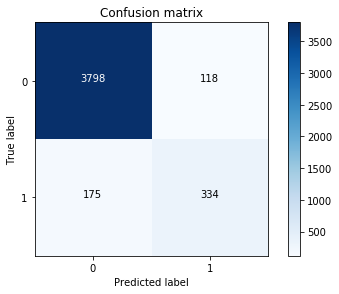

Accuracy:  0.93
Precision: 0.74
Recall:    0.66


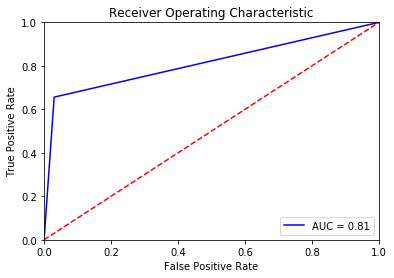

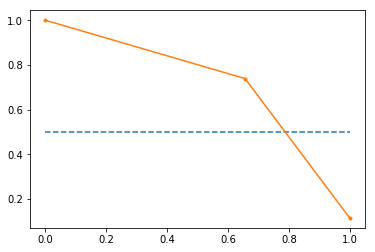

*********************************************************************************************
At Cutoff ..............0.5
Recall metric in the train dataset: 57.95677799607073%


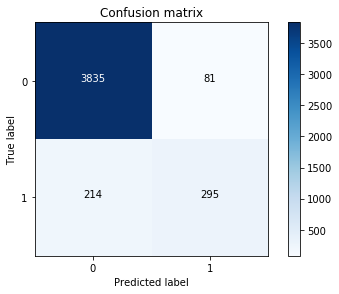

Accuracy:  0.93
Precision: 0.78
Recall:    0.58


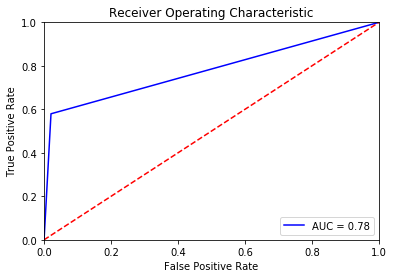

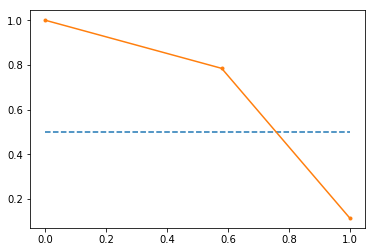

*********************************************************************************************
At Cutoff ..............0.6
Recall metric in the train dataset: 51.080550098231825%


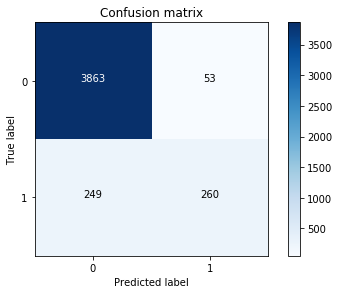

Accuracy:  0.93
Precision: 0.83
Recall:    0.51


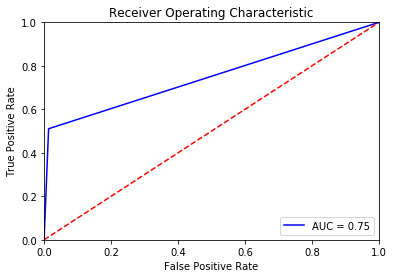

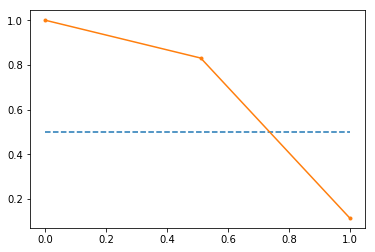

*********************************************************************************************
At Cutoff ..............0.7
Recall metric in the train dataset: 43.81139489194499%


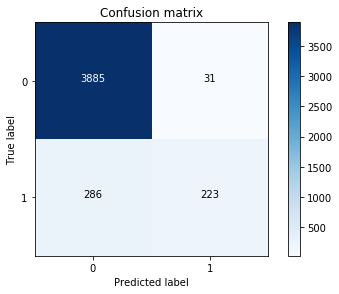

Accuracy:  0.93
Precision: 0.88
Recall:    0.44


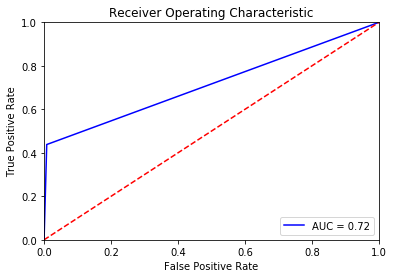

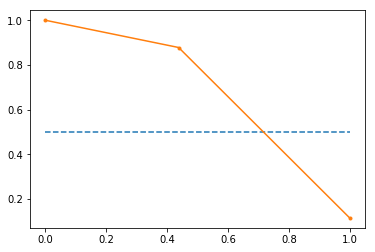

*********************************************************************************************
At Cutoff ..............0.8
Recall metric in the train dataset: 38.89980353634578%


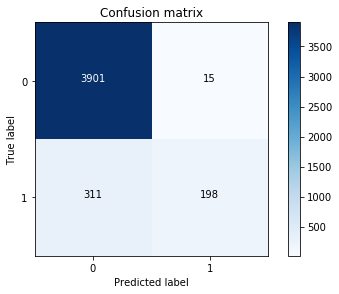

Accuracy:  0.93
Precision: 0.93
Recall:    0.39


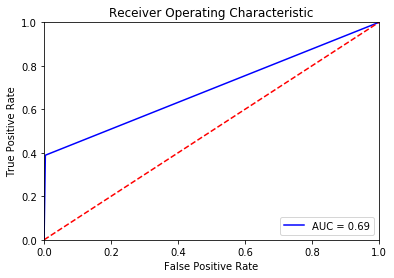

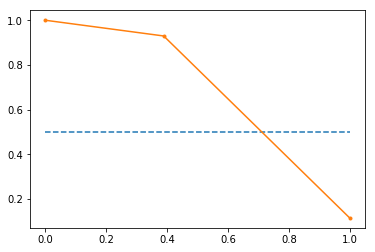

In [40]:
#Logistic regression - With PCA - Partial Balanced Data
pca_model = decomposition.PCA(n_components=N_COMPONENTS)
pca_model.fit(X)
pca_data = pd.DataFrame(pca_model.transform(X))

#pca_data['intercept'] = 1.0
logit_model = LogisticRegression(random_state=0).fit(x_train, y_train)

# Get prediction probabilities for the test set.
y_predict_proba = logit_model.predict_proba(x_test)

n_samples = len(y_test)
cutoff = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
class_names = [0,1]

for i in cutoff:
    index = cutoff.index(i)
    print('*********************************************************************************************')
    Case = 'At Cutoff ..............'
    print(Case + str(cutoff[index]))
    y_predict = [int(proba[1] > cutoff[index]) for proba in y_predict_proba]
    M = confusion_matrix(y_test, y_predict)
        
    print("Recall metric in the train dataset: {}%".format(100*M[1,1]/(M[1,0]+M[1,1])))
   
    plt.figure()
    plot_confusion_matrix(M , classes=class_names, title='Confusion matrix')
    plt.show()
    print('Accuracy:  %.2f' % ((M[0][0] + M[1][1]) / n_samples))
    print('Precision: %.2f' % (M[1][1] / (M[0][1] + M[1][1])))
    print('Recall:    %.2f' % (M[1][1] / (M[1][0] + M[1][1])))
    
    plotROC(y_predict)
    
    plotPrecisionRecallCurve(y_predict)

#### Next, with Penalized SVM model

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


*********************************************************************************************
At Cutoff ..............0.2
Recall metric in the train dataset: 86.05108055009823%


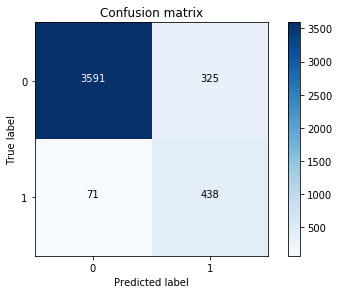

Accuracy:  0.91
Precision: 0.57
Recall:    0.86


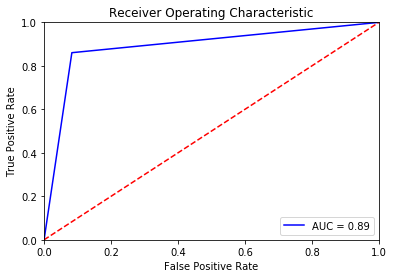

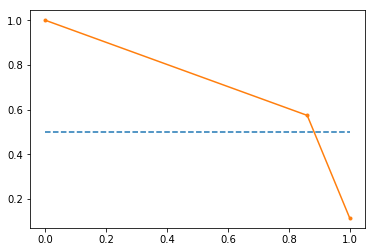

*********************************************************************************************
At Cutoff ..............0.3
Recall metric in the train dataset: 81.33595284872298%


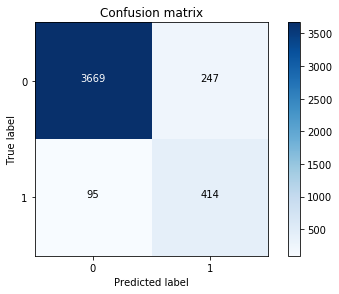

Accuracy:  0.92
Precision: 0.63
Recall:    0.81


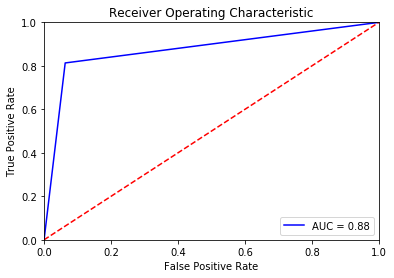

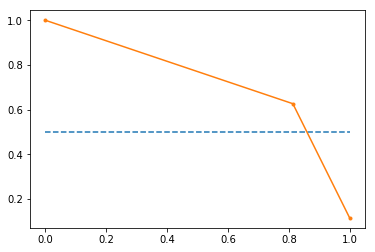

*********************************************************************************************
At Cutoff ..............0.4
Recall metric in the train dataset: 78.58546168958743%


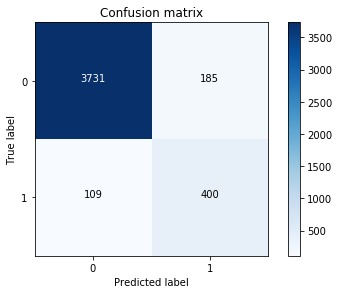

Accuracy:  0.93
Precision: 0.68
Recall:    0.79


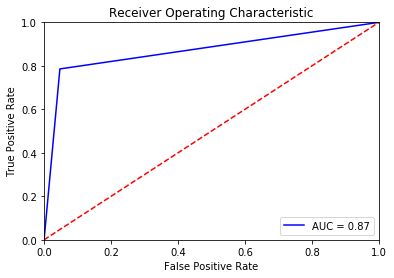

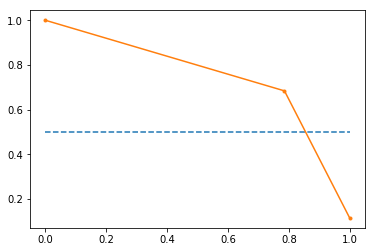

*********************************************************************************************
At Cutoff ..............0.5
Recall metric in the train dataset: 71.11984282907662%


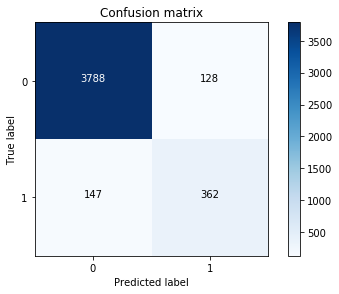

Accuracy:  0.94
Precision: 0.74
Recall:    0.71


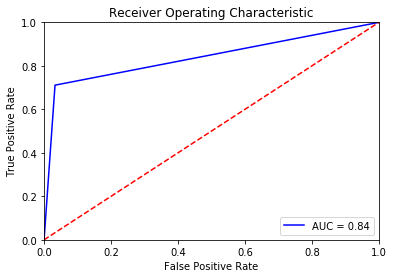

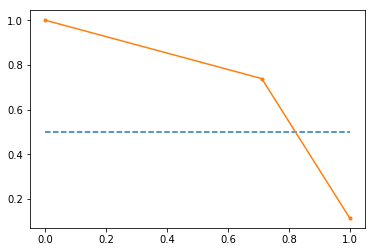

*********************************************************************************************
At Cutoff ..............0.6
Recall metric in the train dataset: 62.082514734774065%


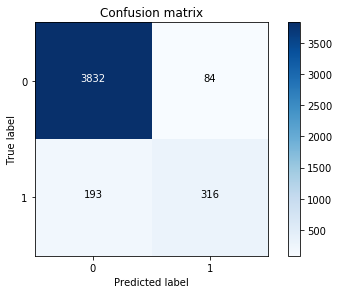

Accuracy:  0.94
Precision: 0.79
Recall:    0.62


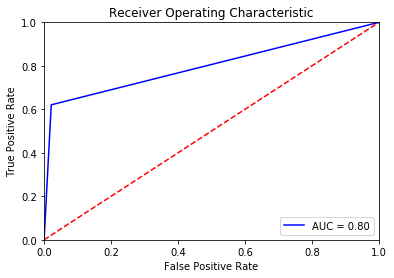

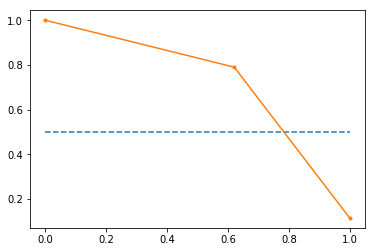

*********************************************************************************************
At Cutoff ..............0.7
Recall metric in the train dataset: 45.97249508840864%


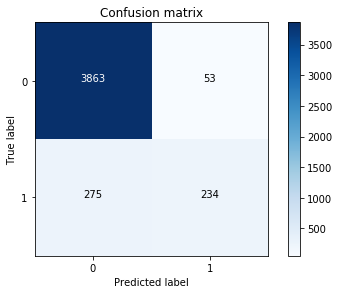

Accuracy:  0.93
Precision: 0.82
Recall:    0.46


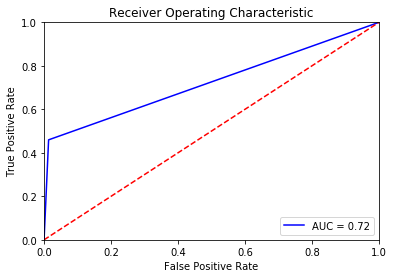

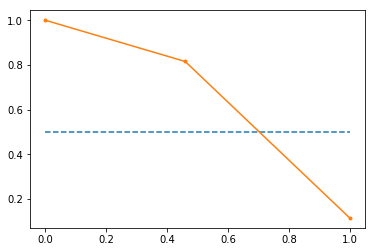

*********************************************************************************************
At Cutoff ..............0.8
Recall metric in the train dataset: 20.6286836935167%


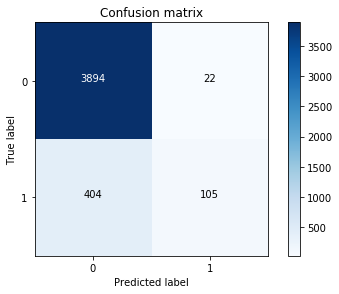

Accuracy:  0.90
Precision: 0.83
Recall:    0.21


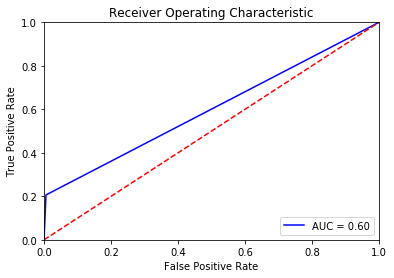

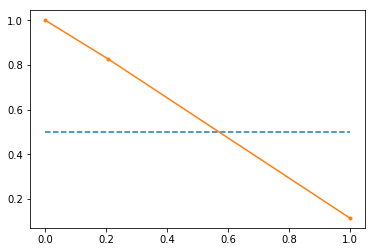

In [41]:
#Penalized SVM on Partial Balanced Dataset

#Imbalance in dataset - Let's try SVC without PCA first with Linear Kernel
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

SVC_classifier = SVC(kernel='rbf', class_weight='balanced', probability=True).fit(x_train, y_train)
# Get prediction probabilities for the test set.
y_predict_proba = SVC_classifier.predict_proba(x_test)

n_samples = len(y_test)
cutoff = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
class_names = [0,1]

for i in cutoff:
    index = cutoff.index(i)
    print('*********************************************************************************************')
    Case = 'At Cutoff ..............'
    print(Case + str(cutoff[index]))
    y_predict = [int(proba[1] > cutoff[index]) for proba in y_predict_proba]
    M = confusion_matrix(y_test, y_predict)
        
    print("Recall metric in the train dataset: {}%".format(100*M[1,1]/(M[1,0]+M[1,1])))
   
    plt.figure()
    plot_confusion_matrix(M , classes=class_names, title='Confusion matrix')
    plt.show()
    print('Accuracy:  %.2f' % ((M[0][0] + M[1][1]) / n_samples))
    print('Precision: %.2f' % (M[1][1] / (M[0][1] + M[1][1])))
    print('Recall:    %.2f' % (M[1][1] / (M[1][0] + M[1][1])))
    
    plotROC(y_predict)
    
    plotPrecisionRecallCurve(y_predict)

#### Finally, with Random Forest Classifier  model

*********************************************************************************************
At Cutoff ..............0.2
Recall metric in the train dataset: 83.49705304518665%


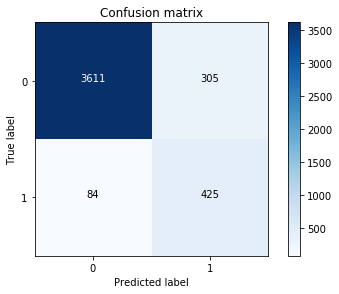

Accuracy:  0.91
Precision: 0.58
Recall:    0.83


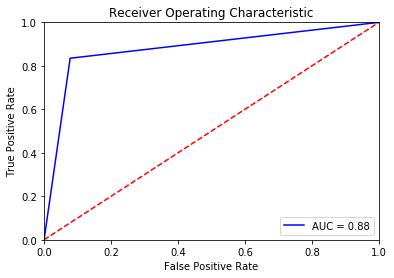

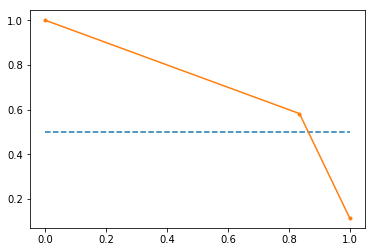

*********************************************************************************************
At Cutoff ..............0.3
Recall metric in the train dataset: 76.62082514734774%


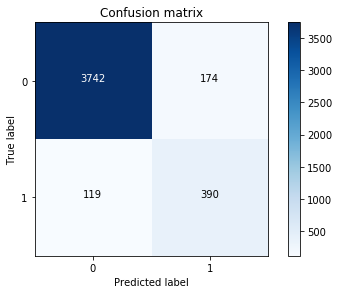

Accuracy:  0.93
Precision: 0.69
Recall:    0.77


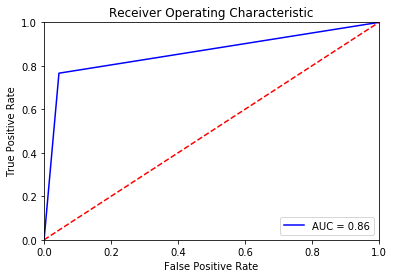

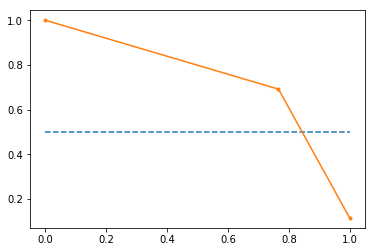

*********************************************************************************************
At Cutoff ..............0.4
Recall metric in the train dataset: 70.92337917485266%


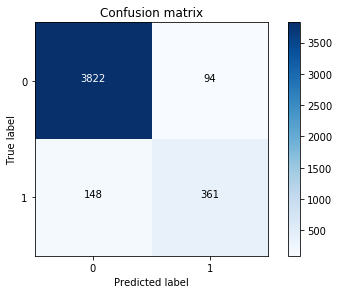

Accuracy:  0.95
Precision: 0.79
Recall:    0.71


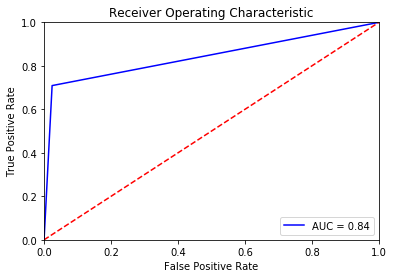

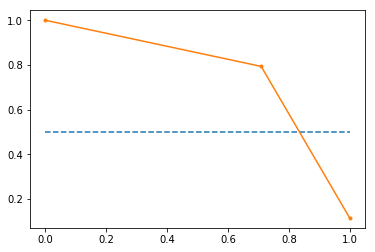

*********************************************************************************************
At Cutoff ..............0.5
Recall metric in the train dataset: 62.082514734774065%


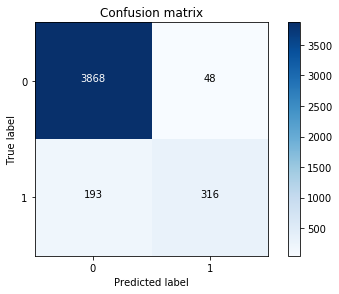

Accuracy:  0.95
Precision: 0.87
Recall:    0.62


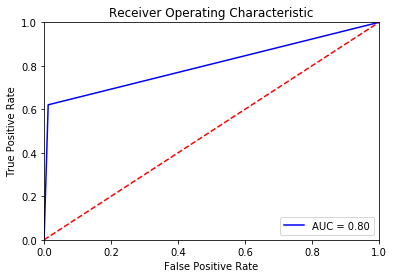

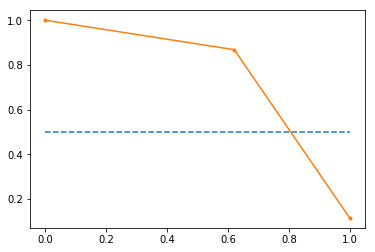

*********************************************************************************************
At Cutoff ..............0.6
Recall metric in the train dataset: 53.63457760314342%


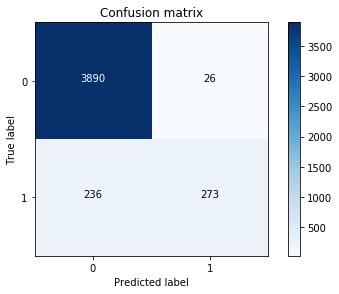

Accuracy:  0.94
Precision: 0.91
Recall:    0.54


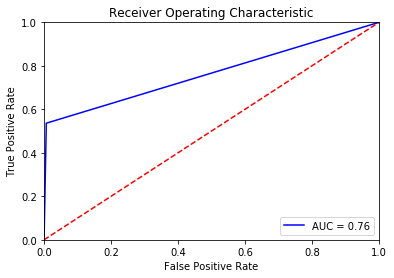

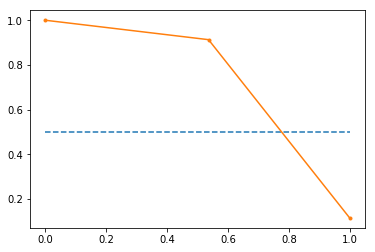

*********************************************************************************************
At Cutoff ..............0.7
Recall metric in the train dataset: 45.579567779960705%


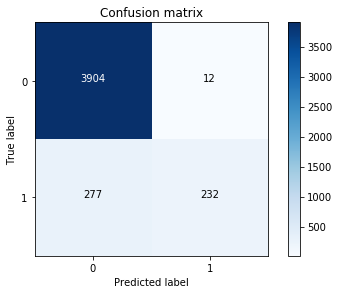

Accuracy:  0.93
Precision: 0.95
Recall:    0.46


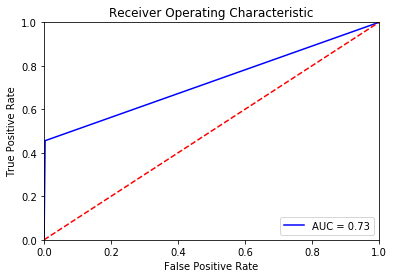

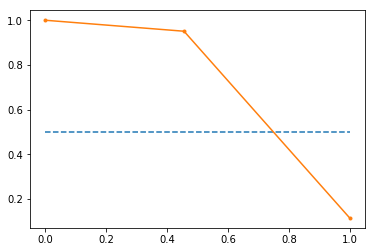

*********************************************************************************************
At Cutoff ..............0.8
Recall metric in the train dataset: 36.345776031434184%


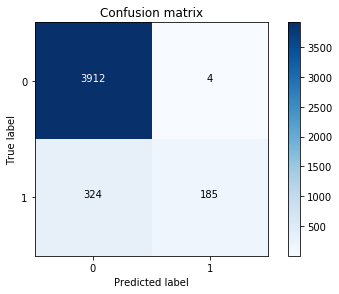

Accuracy:  0.93
Precision: 0.98
Recall:    0.36


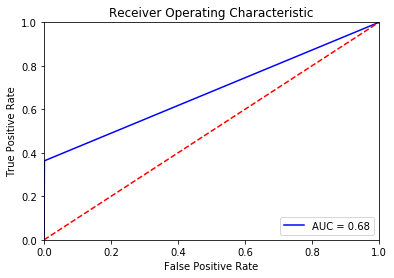

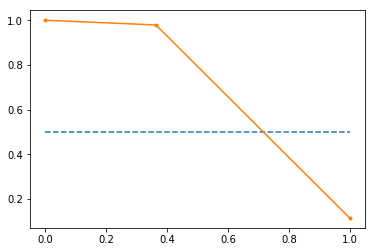

In [42]:
#Random Forest Classifier on Partial Balanced Dataset
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(class_weight='balanced',n_estimators=400).fit(x_train, y_train)

y_predict_proba = RFC.predict_proba(x_test)

n_samples = len(y_test)
cutoff = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
class_names = [0,1]

for i in cutoff:
    index = cutoff.index(i)
    print('*********************************************************************************************')
    Case = 'At Cutoff ..............'
    print(Case + str(cutoff[index]))
    y_predict = [int(proba[1] > cutoff[index]) for proba in y_predict_proba]
    M = confusion_matrix(y_test, y_predict)
        
    print("Recall metric in the train dataset: {}%".format(100*M[1,1]/(M[1,0]+M[1,1])))
   
    plt.figure()
    plot_confusion_matrix(M , classes=class_names, title='Confusion matrix')
    plt.show()
    print('Accuracy:  %.2f' % ((M[0][0] + M[1][1]) / n_samples))
    print('Precision: %.2f' % (M[1][1] / (M[0][1] + M[1][1])))
    print('Recall:    %.2f' % (M[1][1] / (M[1][0] + M[1][1])))
    
    plotROC(y_predict)
    
    plotPrecisionRecallCurve(y_predict)

### Comparative Tabulated Results
#### Evaluation Metrics at different cut-off points across 3 models for Imbalanced & Partially Balanced data. 

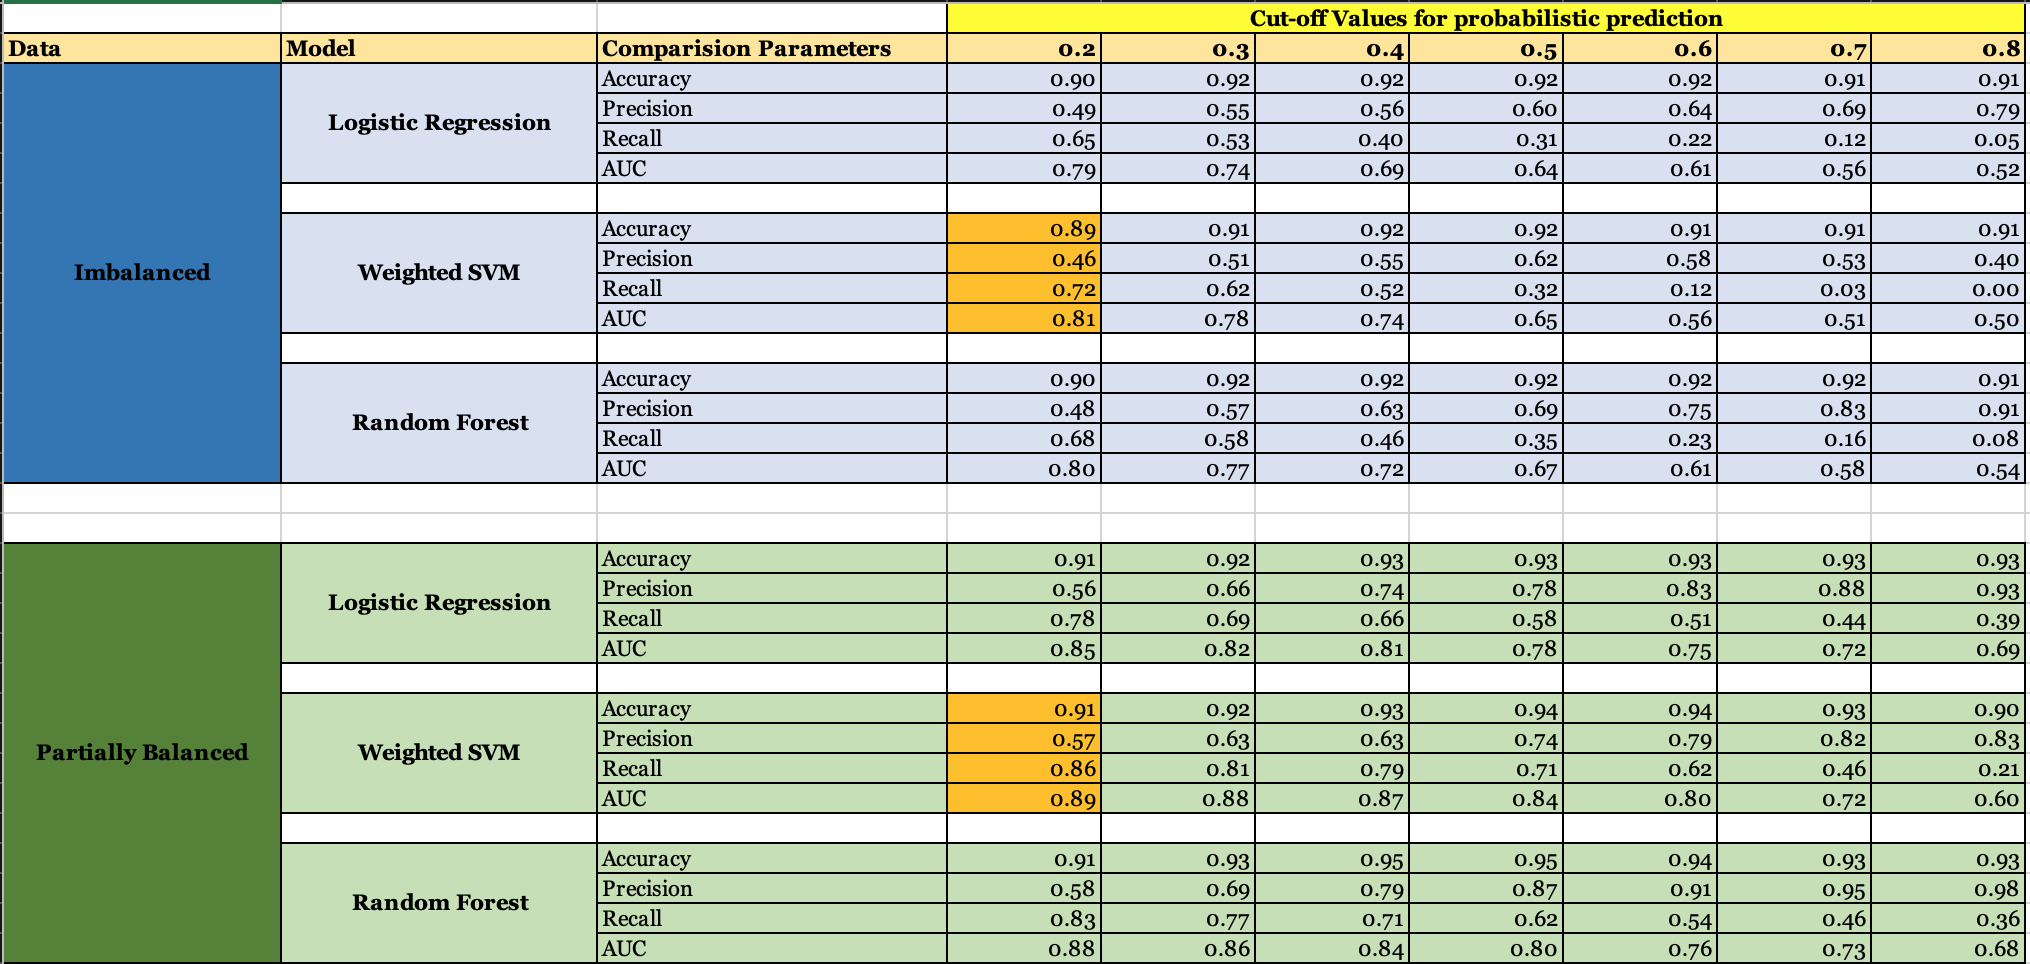

### Conclusion


We have built 3 different models (Logistic Regression, Weighted SVM & Random Forest) for both Imbalanced & Partially Balanced data. Given that we are predicting churn, we need to balance both Accuracy and Recall while selecting the final predictive model. Based on the provided data set, we can conclude the following:
1. For Imbalanced (high-value) customer data, the weighted (or penalized) SVM model at cutoff of 0.2 provides an accuracy of 0.89 and recall of 0.72 which is fairly reasonable to select as the final model.

2. For partially balanced (high-value) customer data, again, the weighted (or penalized) SVM model at cutoff of 0.2 provides an accuracy of 0.91 and recall of 0.89 which is quite good to select as the final model.